In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV
from phik import phik_matrix
from math import pi
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve


## Descripción del Dataset

En este conjunto de datos, encontrarás cinco archivos con las estadísticas al final de cada campo de batalla. Las estadísticas comunes (columnas) en todos los archivos son:

- **Code**: código del campo de batalla (no es necesario para el análisis).
- **Faction**: facción del jugador (Horda o Alianza).
- **Class**: clase del jugador (guerrero, paladín, cazador, pícaro, sacerdote, caballero de la muerte, chamán, mago, brujo, monje, druida, cazador de demonios).
- **KB**: número de muertes letales infligidas por el jugador.
- **D**: número de veces que el jugador murió.
- **HK**: número de asesinatos en los que el jugador o su grupo contribuyeron.
- **DD**: daño infligido por el jugador.
- **HD**: sanación realizada por el jugador.
- **Honor**: honor otorgado al jugador.
- **Win**: 1 si el jugador ganó.
- **Lose**: 1 si el jugador perdió.
- **Rol**: "dps" si el jugador es un repartidor de daño; "heal" si el jugador se enfoca en sanar aliados. Ten en cuenta que no todas las clases pueden ser sanadores, solo chamán, paladín, sacerdote, monje y druida, pero todas las clases pueden ser repartidores de daño.
- **BE**: algunas semanas hay un evento de bonificación, cuando el honor ganado se incrementa. 1 si el campo de batalla ocurrió durante esa semana.

Estas columnas, más la columna **battleground**, están en el archivo `wowbgs.csv`. La columna *battleground* representa el tipo de campo de batalla:

- **AB**: Cuenca de Arathi.
- **BG**: Batalla por Gilneas.
- **DG**: Grieta Aullante.
- **ES**: Ojo de la Tormenta.
- **SA**: Playa de los Ancestros.
- **SM**: Minas Lonjaplata.
- **SS**: Costa Hirviente.
- **TK**: Templo de Kotmogu.
- **TP**: Cumbres Gemelas.
- **WG**: Garganta Grito de Guerra.


#### Cargamos los datos

In [343]:
df = pd.read_csv("wowbgs.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3726 entries, 0 to 3725
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Battleground  3726 non-null   object 
 1   Code          3726 non-null   object 
 2   Faction       3726 non-null   object 
 3   Class         3726 non-null   object 
 4   KB            3726 non-null   int64  
 5   D             3726 non-null   int64  
 6   HK            3726 non-null   int64  
 7   DD            3726 non-null   int64  
 8   HD            3726 non-null   int64  
 9   Honor         3726 non-null   int64  
 10  Win           1889 non-null   float64
 11  Lose          1837 non-null   float64
 12  Rol           3726 non-null   object 
 13  BE            529 non-null    float64
dtypes: float64(3), int64(6), object(5)
memory usage: 407.7+ KB


# Feature Engineering

#### Convertimos a binario la variable target **Win** (Victoria = 1, Derrota = 0)

In [344]:
def win_lose(row):
    if row["Win"] != 1.0:
        return 0
    else:
        return 1
df["Win"]= df.apply(win_lose, axis= 1)

#### Borramos las variable **"Lose"** ya que la hemos unificado con **"Win"** y dará problemas con el modelo.
- También borramos las variables **"BE"** y **"Code"** porque no aportan valor al dataset.

In [345]:
df =df.drop(columns=["BE", "Lose","Code"])

#### Simplificando feature "Battleground"

In [346]:
def bg(row):
    if row["Battleground"] == "TP" or row["Battleground"] == "WG":
        return "Banderas"
    elif row["Battleground"] == "AB" or row["Battleground"] == "BG" or row["Battleground"] == "DG":
        return "Defender_bases"
    elif row["Battleground"] == "ES" or row["Battleground"] == "SM" or row["Battleground"] == "TK":
        return "Banderas_y_bases"
    else:
        return "Otros"

df["Battleground"] = df.apply(bg, axis=1)

# Contar las ocurrencias de cada categoría
df["Battleground"].value_counts()


Battleground
Banderas_y_bases    1473
Defender_bases      1072
Banderas            1063
Otros                118
Name: count, dtype: int64

### Añadimos una variable **Tipo_clase** que corresponde a si es un personaje a melee a distancia o un caster.

In [347]:
def clases(row):
    if row["Class"] == "Mage" or row["Class"] == "Warlock" or row["Class"] == "Priest":
        return "Casters"
    elif row["Class"] == "Warrior" or row["Class"] == "Death Knight" or row["Class"] == "Paladin" or row["Class"] == "Rogue" or row["Class"] == "Demon Hunter":
        return "Melee"
    else:
        return "Hybrid_Ranged_melee"
    
df["Tipo_clase"] = df.apply(clases, axis = 1)

df["Tipo_clase"].value_counts()

Tipo_clase
Melee                  1529
Hybrid_Ranged_melee    1280
Casters                 917
Name: count, dtype: int64

#### Mejoramos la variable **"Rol"** ya que hay varias clases hybridas por lo que clasificamos como "**DPS**"" si el daño es mayor al heal y viceversa.

In [348]:
def rol_mejorado(row):
    for pj in row["Rol"]:
        if row["DD"] > row["HD"]:
            pj = "DPS"
            return pj
    pj ="HEAL"
    return pj

df["Rol"] = df.apply(rol_mejorado, axis = 1)

df["Rol"].value_counts()

Rol
DPS     2950
HEAL     776
Name: count, dtype: int64

---

### Media de Muertes (D_Mean)
- Descripción: Calcula la media de muertes (D) por clase en cada campo de batalla.
- Utilidad: Permite comparar la tasa de muertes de un jugador con el promedio de su clase en el mismo campo de batalla, evaluando su supervivencia relativa.

In [349]:
#Media de numero de contribución en  muertes por clase y BG
D_Mean = df.groupby(["Class","Battleground"])["D"].transform("mean").round(2)

df["D_Mean"] = D_Mean

df[["Battleground","Class","D","D_Mean"]].head()

Battleground         Class  D  D_Mean
0     Banderas        Hunter  3    3.40
1     Banderas  Death Knight  3    2.83
2     Banderas       Paladin  1    2.78
3     Banderas       Paladin  2    2.78
4     Banderas         Rogue  3    2.70

### Media de Contribuciones en Muertes (HK_Mean) y de golpes de gracia (KB_Mean)
- Descripción: La media de contribuciones en muertes (HK) por clase en cada campo de batalla.
- Utilidad: Facilita la comparación del rendimiento de cada jugador respecto al promedio de su clase en el mismo campo de batalla.

- HK

In [350]:
#Media de numero de contribución en  muertes por clase y BG
HK_Mean = df.groupby(["Class","Battleground"])["HK"].transform("mean").round(2)

df["HK_Mean"] = HK_Mean

df[["Battleground","Class","HK","HK_Mean"]].head()

Battleground         Class  HK  HK_Mean
0     Banderas        Hunter  14    24.42
1     Banderas  Death Knight  12    25.35
2     Banderas       Paladin  19    23.82
3     Banderas       Paladin  25    23.82
4     Banderas         Rogue  23    22.38

- KB

In [351]:
#Media de numero de muertes (golpes de gracia) por clase y BG
KB_Mean = df.groupby(["Class","Battleground"])["KB"].transform("mean").round(2)

df["KB_Mean"] = KB_Mean

df[["Battleground","Class","KB","KB_Mean"]].head()

Battleground         Class  KB  KB_Mean
0     Banderas        Hunter   1     3.40
1     Banderas  Death Knight   1     3.39
2     Banderas       Paladin   0     2.93
3     Banderas       Paladin   1     2.93
4     Banderas         Rogue   2     3.07

### Ratio de Daño por Jugador (DD_Ratio)
- Descripción: Este cálculo muestra el ratio de daño infligido por cada jugador en comparación con la media de daño de su clase en el campo de batalla. Se calcula dividiendo el daño de cada jugador (DD) entre la media de daño (Mean_DD) para su clase y battleground.
- Utilidad: Es útil para evaluar el rendimiento individual de cada jugador dentro de su clase. Un DD_Ratio mayor que 1 indica que el jugador ha infligido más daño que el promedio de su clase, lo que sugiere un desempeño destacado en esa partida.

In [352]:
# 1. Calcula la media de DD por clase y battleground
mean_dd_per_class_bg = df.groupby(['Class', 'Battleground'])['DD'].mean().round(2).reset_index()

# Renombrar la columna de media para mayor claridad
mean_dd_per_class_bg.columns = ['Class', 'Battleground', 'Mean_DD']

# 2. Hacer un merge para agregar la media al DataFrame original
df = df.merge(mean_dd_per_class_bg, on=['Class', 'Battleground'], how='left')

# 3. Calcular el ratio de DD en comparación con la media
df['DD_Ratio'] = df['DD'] / df['Mean_DD']

# Mostrar el resultado
df[['Battleground', 'Class', 'DD', 'Mean_DD', 'DD_Ratio']].head()

Battleground         Class     DD   Mean_DD  DD_Ratio
0     Banderas        Hunter  48155  47947.17  1.004335
1     Banderas  Death Knight  27025  53111.88  0.508832
2     Banderas       Paladin    824  37425.84  0.022017
3     Banderas       Paladin   7046  37425.84  0.188266
4     Banderas         Rogue  65483  36901.84  1.774519

### Ratio de Heal por Jugador (HD_Ratio)
- Descripción: Este cálculo muestra el ratio de sanación realizada por cada jugador en comparación con la media de sanación de su clase en el campo de batalla. Se calcula dividiendo la sanación de cada jugador (HD) entre la media de sanación (Mean_HD) para su clase y battleground.
- Utilidad: Es útil para evaluar el rendimiento individual de cada jugador dentro de su clase. Un HD_Ratio mayor que 1 indica que el jugador ha realizado más sanación que el promedio de su clase, lo que sugiere un desempeño destacado en esa partida


In [353]:
# 1. Calcula la media de HD por clase y battleground
mean_hd_per_class_bg = df.groupby(['Class', 'Battleground'])['HD'].mean().round(2).reset_index()

# Renombrar la columna de media para mayor claridad
mean_hd_per_class_bg.columns = ['Class', 'Battleground', 'Mean_HD']

# 2. Hacer un merge para agregar la media al DataFrame original
df = df.merge(mean_hd_per_class_bg, on=['Class', 'Battleground'], how='left')

# 3. Calcular el ratio de HD en comparación con la media
df['HD_Ratio'] = df['HD'] / df['Mean_HD']

# Mostrar el resultado
df[['Battleground', 'Class', 'HD', 'Mean_HD', 'HD_Ratio']].head()

Battleground         Class     HD   Mean_HD  HD_Ratio
0     Banderas        Hunter   6641   7303.21  0.909326
1     Banderas  Death Knight   7106  21251.04  0.334384
2     Banderas       Paladin  93879  31774.52  2.954537
3     Banderas       Paladin  98599  31774.52  3.103084
4     Banderas         Rogue  19629   6980.30  2.812057

----

### Dataset final tras el proceso de preparación de datos y creación de nuevas características

In [354]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3726 entries, 0 to 3725
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Battleground  3726 non-null   object 
 1   Faction       3726 non-null   object 
 2   Class         3726 non-null   object 
 3   KB            3726 non-null   int64  
 4   D             3726 non-null   int64  
 5   HK            3726 non-null   int64  
 6   DD            3726 non-null   int64  
 7   HD            3726 non-null   int64  
 8   Honor         3726 non-null   int64  
 9   Win           3726 non-null   int64  
 10  Rol           3726 non-null   object 
 11  Tipo_clase    3726 non-null   object 
 12  D_Mean        3726 non-null   float64
 13  HK_Mean       3726 non-null   float64
 14  KB_Mean       3726 non-null   float64
 15  Mean_DD       3726 non-null   float64
 16  DD_Ratio      3726 non-null   float64
 17  Mean_HD       3726 non-null   float64
 18  HD_Ratio      3726 non-null 

In [355]:
df.head()

Battleground   Faction         Class  KB  D  HK     DD     HD  Honor  Win  \
0     Banderas     Horde        Hunter   1  3  14  48155   6641    532    1   
1     Banderas     Horde  Death Knight   1  3  12  27025   7106    377    1   
2     Banderas  Alliance       Paladin   0  1  19    824  93879    252    0   
3     Banderas  Alliance       Paladin   1  2  25   7046  98599    274    0   
4     Banderas  Alliance         Rogue   2  3  23  65483  19629    268    0   

    Rol           Tipo_clase  D_Mean  HK_Mean  KB_Mean   Mean_DD  DD_Ratio  \
0   DPS  Hybrid_Ranged_melee    3.40    24.42     3.40  47947.17  1.004335   
1   DPS                Melee    2.83    25.35     3.39  53111.88  0.508832   
2  HEAL                Melee    2.78    23.82     2.93  37425.84  0.022017   
3  HEAL                Melee    2.78    23.82     2.93  37425.84  0.188266   
4   DPS                Melee    2.70    22.38     3.07  36901.84  1.774519   

    Mean_HD  HD_Ratio  
0   7303.21  0.909326  
1  21251.04  0.334384  
2  31774.52  2.954537  
3  31774.52  3.103084  
4   6980.30  2.812057

In [356]:
df.describe()

KB            D           HK             DD             HD  \
count  3726.000000  3726.000000  3726.000000    3726.000000    3726.000000   
mean      3.015835     3.025497    26.420558   41215.037842   26426.688674   
std       3.141498     2.209958    15.989997   33193.413617   37583.736064   
min       0.000000     0.000000     0.000000       0.000000       0.000000   
25%       0.000000     1.000000    14.000000   15490.500000    5919.250000   
50%       2.000000     3.000000    25.000000   34107.500000   12070.500000   
75%       5.000000     4.000000    38.000000   58958.000000   26695.500000   
max      23.000000    12.000000    95.000000  246000.000000  325000.000000   

             Honor          Win       D_Mean      HK_Mean      KB_Mean  \
count  3726.000000  3726.000000  3726.000000  3726.000000  3726.000000   
mean    402.816694     0.506978     3.026554    26.421197     3.016345   
std     205.689061     0.500018     0.434732     5.151347     0.836263   
min      25.000000     0.000000     2.150000    19.800000     1.250000   
25%     234.000000     0.000000     2.700000    22.750000     2.430000   
50%     371.500000     1.000000     3.000000    25.080000     3.120000   
75%     529.000000     1.000000     3.330000    29.690000     3.550000   
max    1174.000000     1.000000     5.000000    60.220000     5.670000   

             Mean_DD     DD_Ratio        Mean_HD     HD_Ratio  
count    3726.000000  3726.000000    3726.000000  3726.000000  
mean    41215.038384     1.000000   26426.687794     1.000000  
std     11929.424839     0.814442   20188.686478     0.917177  
min     18115.880000     0.000000    6663.130000     0.000000  
25%     32463.300000     0.404482    8878.620000     0.348445  
50%     42043.360000     0.825133   22440.400000     0.762616  
75%     47997.680000     1.392560   43761.120000     1.372193  
max    111282.170000     6.083974  126814.700000    10.262966

-----

#### EDA

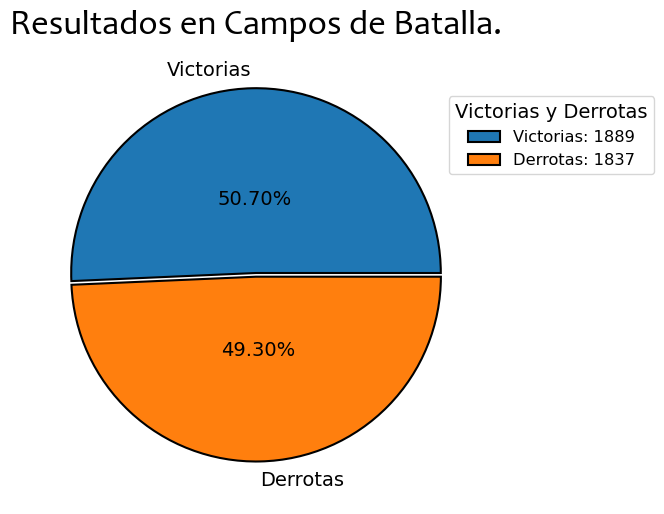

In [357]:
# Contar el número de victorias y derrotas
total_wins = df["Win"].value_counts()  
victorias_derrotas = [total_wins.get(1, 0), total_wins.get(0, 0)]  # Crear lista con victorias y derrotas

# Etiquetas para el gráfico
labels_pie = ['Victorias', 'Derrotas']
labels_legend = [f'Victorias: {victorias_derrotas[0]}', f'Derrotas: {victorias_derrotas[1]}']

# Crear el gráfico de pastel
plt.figure(figsize=(8, 6))
plt.pie(victorias_derrotas, explode=(0, 0.02), labels=labels_pie, startangle=0,
        wedgeprops={"edgecolor": "black", "linewidth": 1.5}, 
        autopct=lambda p: '{:.2f}%'.format(p), pctdistance=0.4)

# Configuración de fuente y título
plt.rcParams['font.size'] = 14
plt.title("Resultados en Campos de Batalla.", fontsize=25, fontname="Candara")
plt.legend(labels_legend, title="Victorias y Derrotas", fontsize="small", bbox_to_anchor=(0.9, 0, 0.2, 0.9))
plt.show()


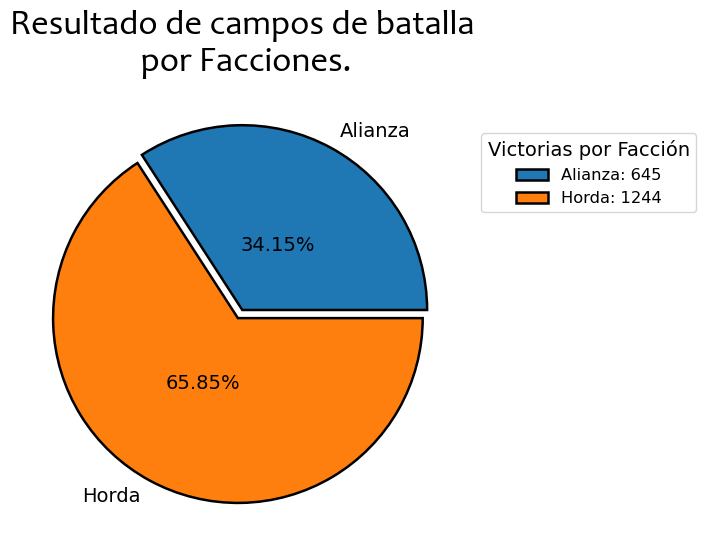

In [358]:

# Contamos cuántas victorias tiene la Alianza
win_alliance = df.loc[(df["Faction"] == "Alliance") & (df["Win"] == 1.0), "Win"].count()

# Contamos cuántas victorias tiene la Horda
win_horde = df.loc[(df["Faction"] == "Horde") & (df["Win"] == 1.0), "Win"].count()

# Creamos la lista de victorias por facción
victorias_faccion = [win_alliance, win_horde]

# Definimos las etiquetas y colores para el gráfico
label_faccion = ["Alianza", "Horda"]
label_faccion_legend = [f'Alianza: {win_alliance}', f'Horda: {win_horde}']

# Crear el gráfico de pastel
plt.figure(figsize=(8, 6))
plt.pie(victorias_faccion, labels=label_faccion, startangle=0,
        explode=(0, 0.05), autopct='%.2f%%', pctdistance=0.4,
        wedgeprops={"linewidth": 1.8, "edgecolor": "black"})

# Configuración del título y leyenda
plt.title("Resultado de campos de batalla\n por Facciones.", fontsize=25, fontname='Candara')
plt.legend(label_faccion_legend, title="Victorias por Facción", fontsize="small", bbox_to_anchor=(1, 0, 0.3, 0.9))
plt.show()


### Gráfico de Barras de Métricas por Clase y Facción

Generamos un gráfico de barras usando `resultado_clases_faccion` para mostrar promedios por **Clase** y **Facción** en cada métrica:

- **curacion_media**: promedio de curación
- **daño_medio**: promedio de daño
- **media_muertes**: media de muertes
- **media_contribución**: media de contribuciones (HK)
- **media_honor**: puntos de honor promedio
- **numero_de_victorias**: total de victorias

In [359]:
# Agrupar por Clase y Facción y calcular diferentes métricas
resultado_clases_faccion = df.groupby(['Class', 'Faction']).agg(
    numero_de_victorias=('Win', 'count'),
    curacion_media=('HD', 'mean'),
    daño_medio=('DD', 'mean'),
    media_muertes=('D', 'mean'),
    media_contribución=('HK', 'mean'),
    media_honor=('Honor', 'mean')
).reset_index()

# Mostrar las primeras filas del resultado
resultado_clases_faccion.head(24)

Class   Faction  numero_de_victorias  curacion_media    daño_medio  \
0   Death Knight  Alliance                  105    22744.009524  58691.142857   
1   Death Knight     Horde                  122    23195.606557  55055.475410   
2   Demon Hunter  Alliance                  150     8749.666667  47969.513333   
3   Demon Hunter     Horde                  142     9310.823944  46348.183099   
4          Druid  Alliance                  225    41955.951111  31160.933333   
5          Druid     Horde                  151    33918.311258  35821.205298   
6         Hunter  Alliance                  193     7395.290155  45574.689119   
7         Hunter     Horde                  148     6674.108108  50155.695946   
8           Mage  Alliance                  178    10656.393258  49303.202247   
9           Mage     Horde                  156     9597.878205  53606.102564   
10          Monk  Alliance                   95    63531.242105  20268.915789   
11          Monk     Horde                   72    59673.777778  22094.736111   
12       Paladin  Alliance                  180    27944.650000  42114.327778   
13       Paladin     Horde                  144    30605.250000  42583.958333   
14        Priest  Alliance                  152    57640.875000  32417.519737   
15        Priest     Horde                  151    61929.980132  40428.754967   
16         Rogue  Alliance                  149     7298.550336  35374.657718   
17         Rogue     Horde                  161     7232.689441  36254.062112   
18        Shaman  Alliance                  113    38881.035398  31643.371681   
19        Shaman     Horde                  283    55474.738516  23288.462898   
20       Warlock  Alliance                  125    22223.936000  55371.056000   
21       Warlock     Horde                  155    23551.141935  53653.322581   
22       Warrior  Alliance                  186     9001.209677  40218.118280   
23       Warrior     Horde                  190    10067.568421  46735.836842   

    media_muertes  media_contribución  media_honor  
0        3.476190           26.295238   454.609524  
1        2.975410           32.188525   398.418033  
2        3.426667           22.580000   427.980000  
3        2.725352           28.767606   408.584507  
4        2.817778           24.724444   416.320000  
5        2.562914           28.596026   380.615894  
6        3.549223           21.202073   391.865285  
7        2.777027           28.743243   354.939189  
8        3.370787           24.578652   423.398876  
9        2.647436           30.596154   379.891026  
10       2.947368           24.957895   458.378947  
11       2.347222           28.236111   379.013889  
12       3.216667           24.461111   413.161111  
13       2.361111           28.930556   407.333333  
14       2.868421           22.598684   398.197368  
15       2.059603           34.139073   409.470199  
16       3.040268           22.154362   413.704698  
17       2.683230           29.347826   399.074534  
18       3.911504           24.867257   401.867257  
19       3.113074           28.561837   405.240283  
20       3.656000           23.360000   395.168000  
21       2.645161           28.580645   391.832258  
22       3.795699           20.790323   418.446237  
23       3.252632           27.415789   359.157895

C:\Users\Usuario\AppData\Local\Temp\ipykernel_3972\4242494962.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
C:\Users\Usuario\AppData\Local\Temp\ipykernel_3972\4242494962.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
C:\Users\Usuario\AppData\Local\Temp\ipykernel_3972\4242494962.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')
C:\Users\Usuario\AppData\Local\Temp\ipykernel_3972\4242494962.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or u

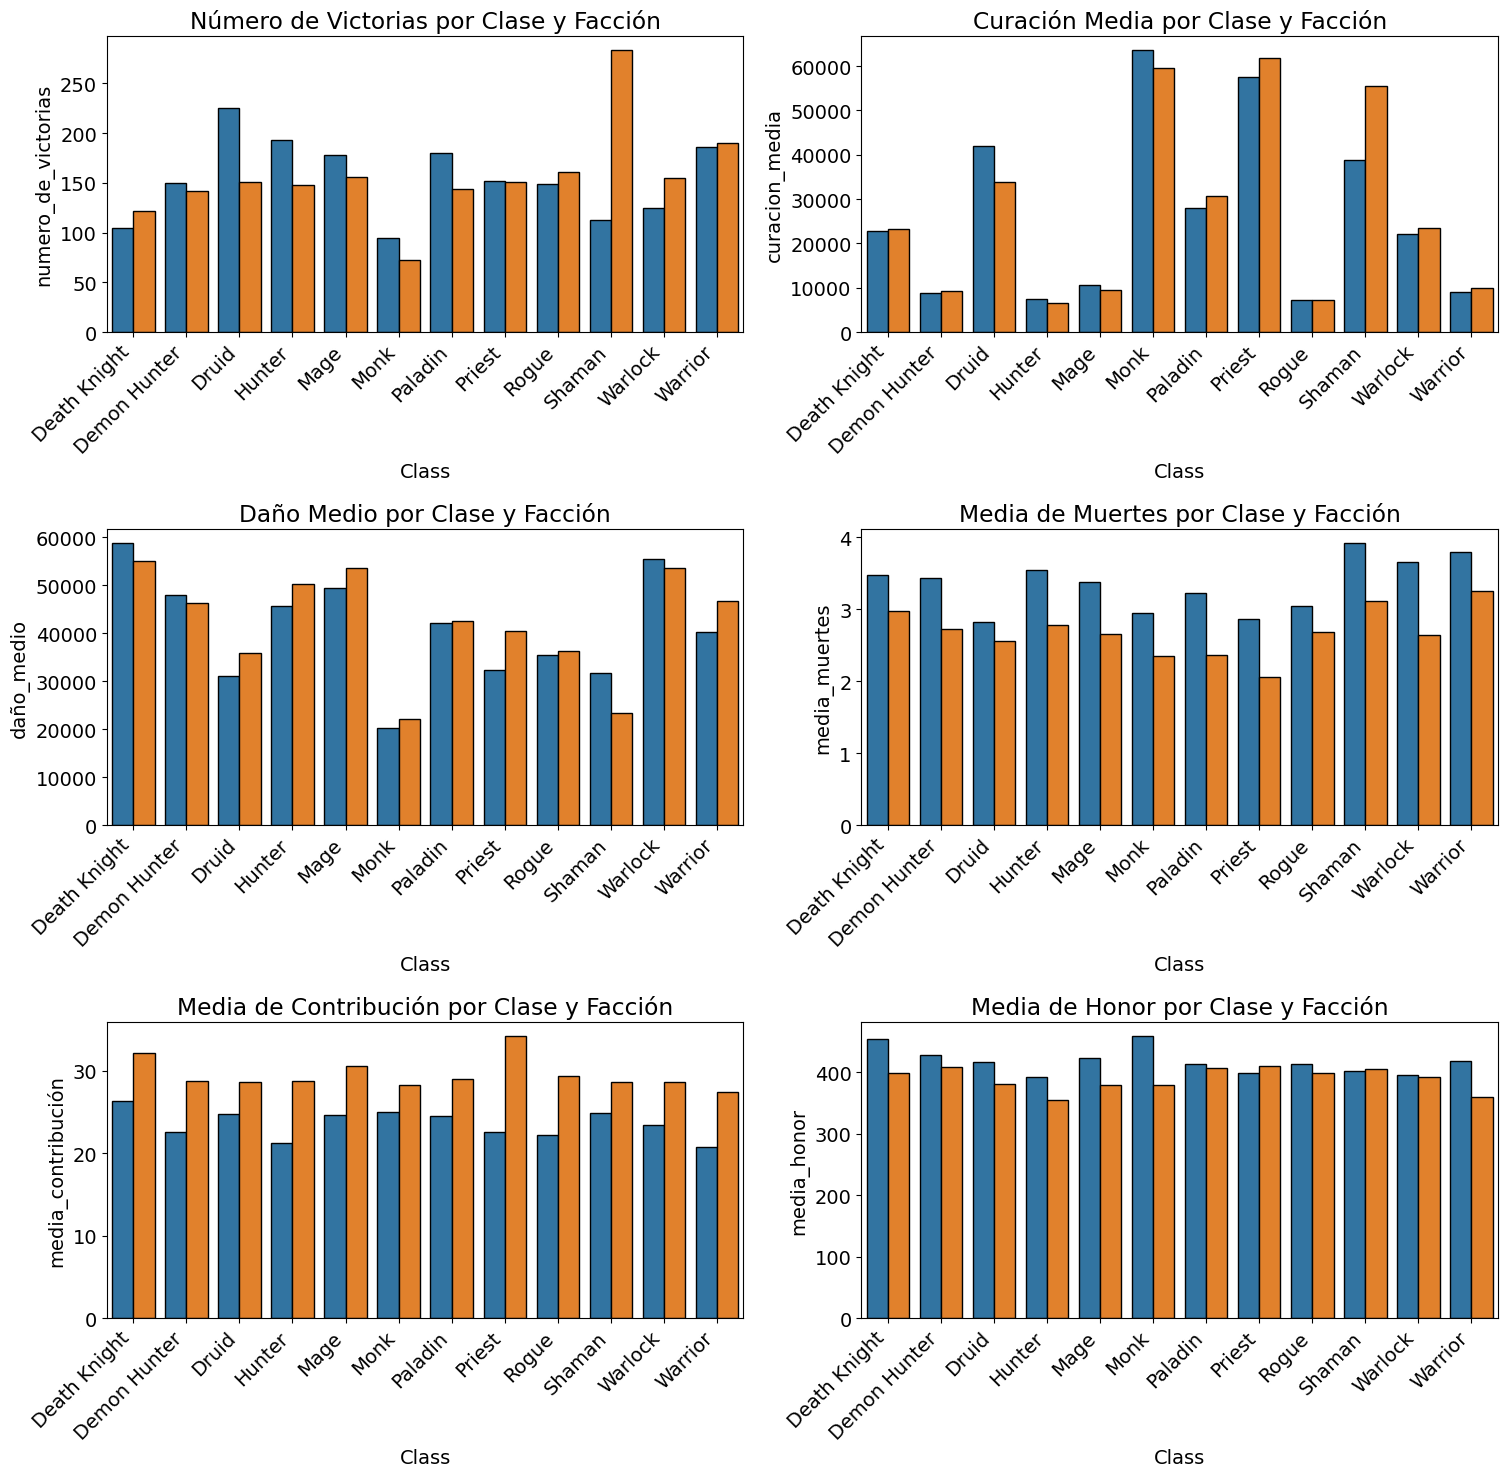

In [360]:
# Crear figura y ejes para 3 filas y 2 columnas (6 gráficos en total)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 15))
axes = axes.flatten()  # Aplanar el arreglo de ejes para facilitar el acceso

# Crear cada gráfico en su respectivo eje sin leyenda
# Gráfico de Número de Victorias
sns.barplot(data=resultado_clases_faccion, x="Class", y="numero_de_victorias", hue="Faction", ax=axes[0], edgecolor="black", legend=False)
axes[0].set_title("Número de Victorias por Clase y Facción")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

# Gráfico de Curación Media
sns.barplot(data=resultado_clases_faccion, x="Class", y="curacion_media", hue="Faction", ax=axes[1], edgecolor="black", legend=False)
axes[1].set_title("Curación Media por Clase y Facción")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

# Gráfico de Daño Medio
sns.barplot(data=resultado_clases_faccion, x="Class", y="daño_medio", hue="Faction", ax=axes[2], edgecolor="black", legend=False)
axes[2].set_title("Daño Medio por Clase y Facción")
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')

# Gráfico de Media de Muertes
sns.barplot(data=resultado_clases_faccion, x="Class", y="media_muertes", hue="Faction", ax=axes[3], edgecolor="black", legend=False)
axes[3].set_title("Media de Muertes por Clase y Facción")
axes[3].set_xticklabels(axes[3].get_xticklabels(), rotation=45, ha='right')

# Gráfico de Media de Contribución
sns.barplot(data=resultado_clases_faccion, x="Class", y="media_contribución", hue="Faction", ax=axes[4], edgecolor="black", legend=False)
axes[4].set_title("Media de Contribución por Clase y Facción")
axes[4].set_xticklabels(axes[4].get_xticklabels(), rotation=45, ha='right')

# Gráfico de Media de Honor
sns.barplot(data=resultado_clases_faccion, x="Class", y="media_honor", hue="Faction", ax=axes[5], edgecolor="black", legend=False)
axes[5].set_title("Media de Honor por Clase y Facción")
axes[5].set_xticklabels(axes[5].get_xticklabels(), rotation=45, ha='right')

# Agregar una única leyenda para todos los subgráficos fuera del gráfico
handles, labels = axes[0].get_legend_handles_labels()  # Obtener las etiquetas y los handles del primer gráfico


# Ajustar el layout para evitar superposiciones
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Ajustar el layout para hacer espacio para la leyenda
plt.show()

#### Radarplot para comparación entre las distintas métricas por clases
- **heal**: promedio de curación
- **dmg**: promedio de daño
- **death**: promedio de muertes
- **hk**: promedio de contribuciones (HK)
- **honor**: puntos de honor promedio


C:\Users\Usuario\AppData\Local\Temp\ipykernel_3972\1178811039.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  my_palette = plt.cm.get_cmap("viridis", len(resultado_normalizado.index))


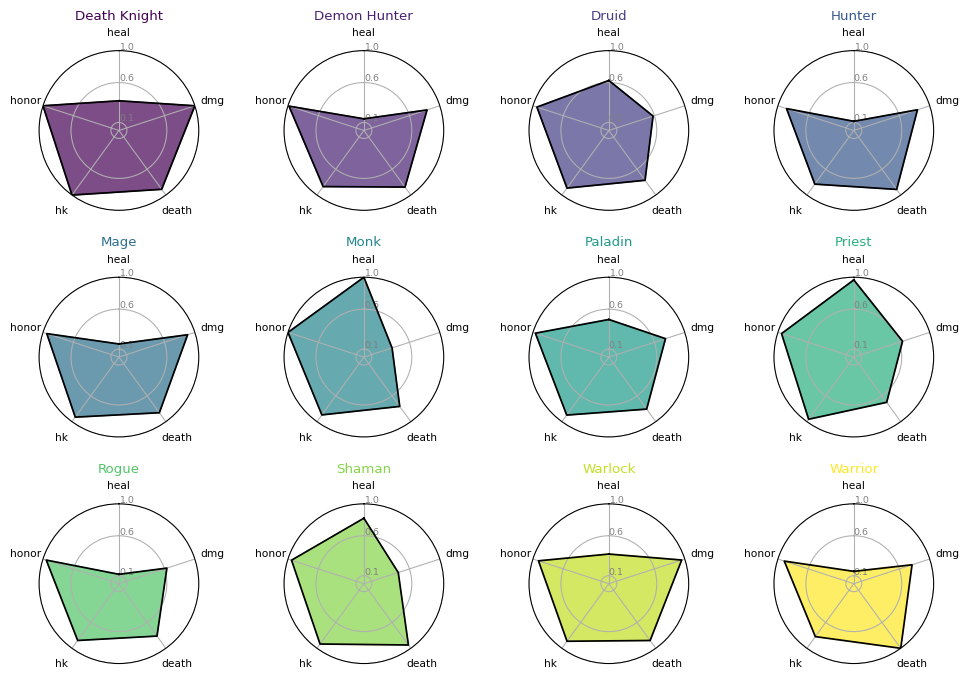

In [361]:
resultado_clases_faccion = df.groupby(['Class']).agg(
    heal =('HD', 'mean'),
    dmg =('DD', 'mean'),
    death=('D', 'mean'),
    hk=('HK', 'mean'),
    honor=('Honor', 'mean')
).reset_index()

# Normalizar los valores para cada métrica
maximos = resultado_clases_faccion[['heal', 'dmg', 'death', 'hk', 'honor']].max()
resultado_normalizado = resultado_clases_faccion.copy()
for col in maximos.index:
    resultado_normalizado[col] = resultado_clases_faccion[col] / maximos[col]

def make_spider(row, title, color):
    # Número de variables
    categories = list(resultado_normalizado)[1:]  # Excluye 'Class'
    N = len(categories)

    # Ángulos para cada eje
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  # Cerrar el círculo

    # Inicializa el gráfico de radar
    ax = plt.subplot(3, 4, row + 1, polar=True)

    # Configura los ejes
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Etiquetas para cada variable
    plt.xticks(angles[:-1], categories, color='black', size=8)

    # Etiquetas del eje radial
    ax.set_rlabel_position(0)
    plt.yticks([0.1, 0.6, 1.0], ["0.1",  "0.6", "1.0"], color="grey", size=7)
    plt.ylim(0, 1)  # Límite para los valores normalizados

    # Valores de la clase normalizados
    values = resultado_normalizado.loc[row].drop('Class').values.flatten().tolist()
    values += values[:1]  # Cerrar el círculo

    # Dibuja el gráfico
    ax.plot(angles, values, color="black", linewidth=1.3, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.7)

    # Añadir título con ajuste de posición
    plt.title(title, size=10, color=color, y=1.15)  # Ajusta 'y' para elevar el título


# Inicializa la figura
my_dpi = 96
plt.figure(figsize=(1000/my_dpi, 700/my_dpi), dpi=my_dpi)

# Crea una paleta de colores usando "viridis"
my_palette = plt.cm.get_cmap("viridis", len(resultado_normalizado.index))

# Bucle para trazar
for row in range(len(resultado_normalizado.index)):
    make_spider(row=row, title=resultado_normalizado['Class'][row], color=my_palette(row))

# Ajustar el diseño
plt.tight_layout()
plt.show()


#### Boxplot de diferentes métricas

Métricas de rendimiento en función del tipo de clase de los jugadores, que incluyen **Híbrido**, **Melee** y **Ranged**, en cada tipo de **Battleground**:

- **KB**: Número de golpes de gracia infligidos por el jugador.
- **D**: Número de veces que el jugador murió.
- **HK**: Número de contribuciones a asesinatos.
- **DD**: Daño infligido por el jugador.


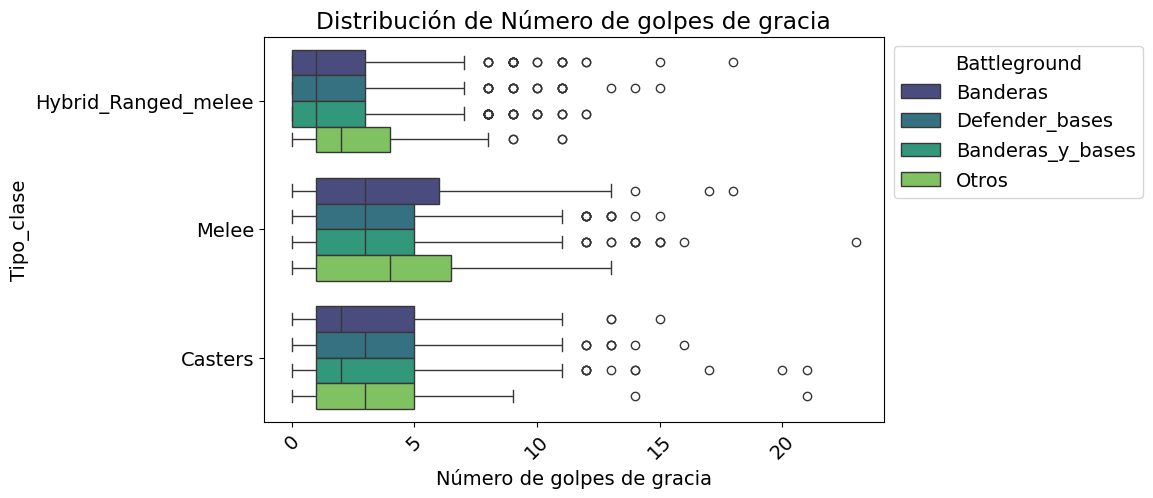

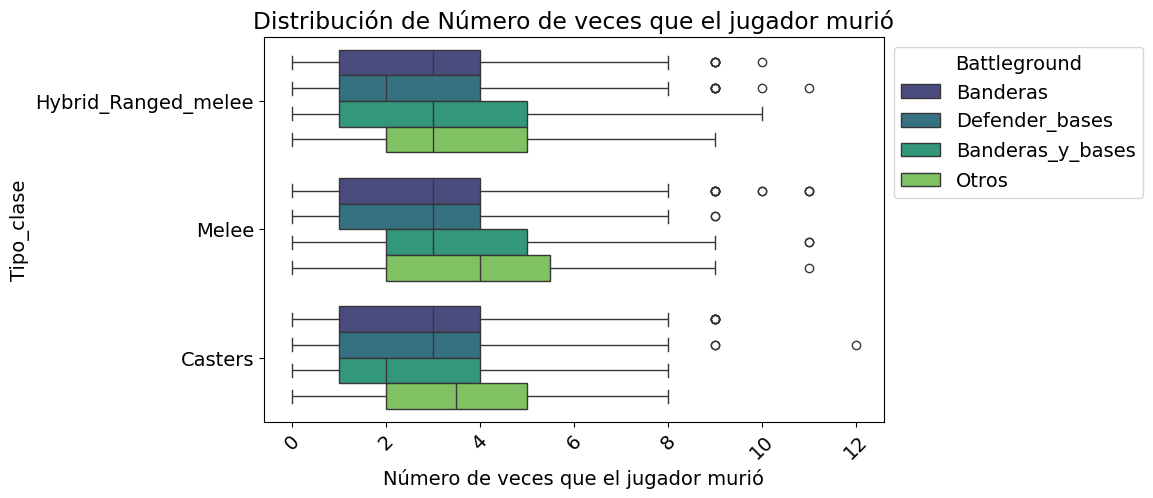

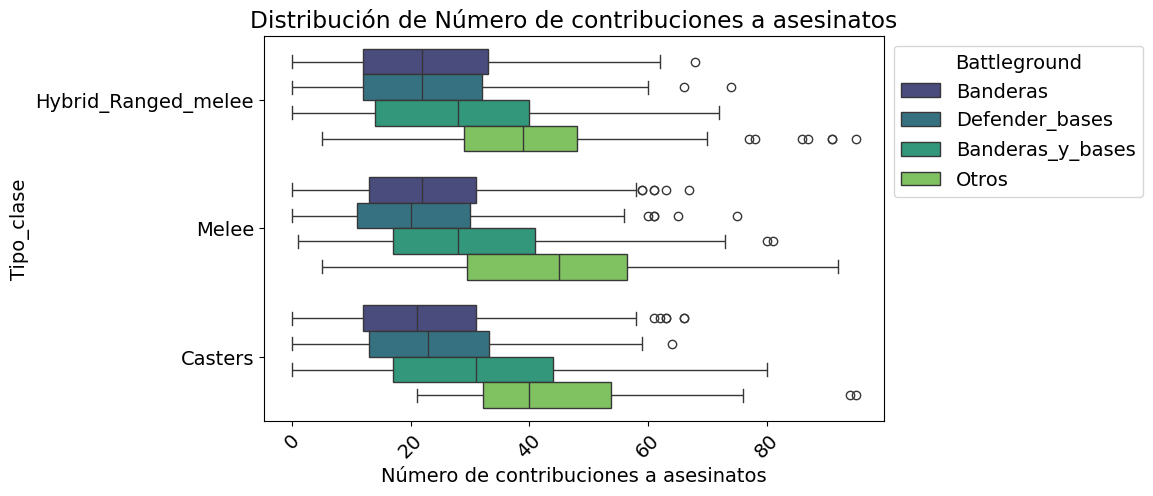

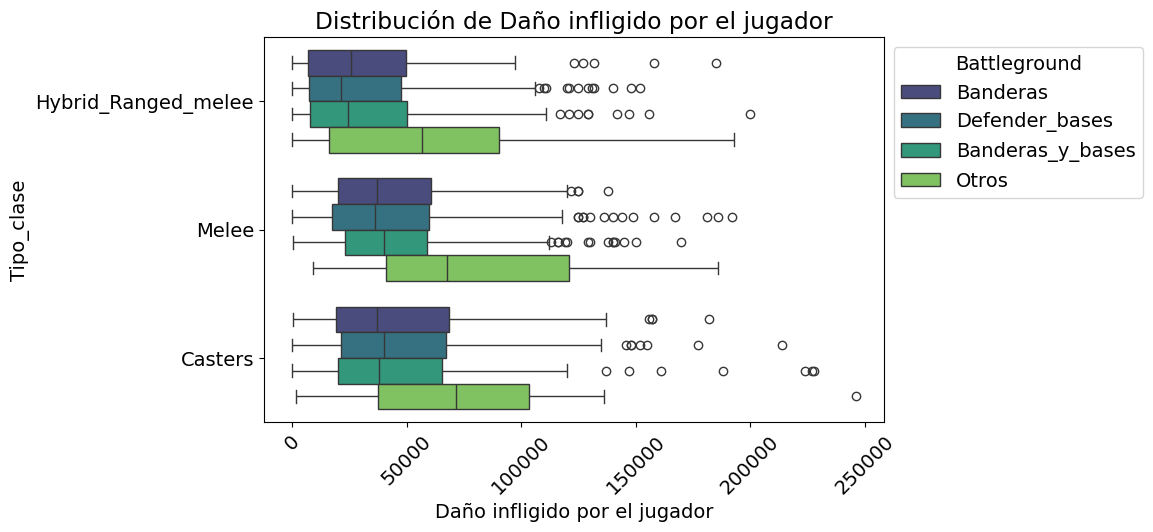

In [362]:
# Aes 1: Diccionario de métricas con descripciones completas
metricas_descripcion = {
    "KB": "Número de golpes de gracia",
    "D": "Número de veces que el jugador murió",
    "HK": "Número de contribuciones a asesinatos",
    "DD": "Daño infligido por el jugador"
}

# Aes 2: Crear una figura para cada métrica
for metrica, descripcion in metricas_descripcion.items():
    plt.figure(figsize=(8, 5))  # Tamaño de cada gráfico

    # Aes 3: Crear el boxplot
    sns.boxplot(data=df, y="Tipo_clase", x=metrica, hue="Battleground", palette="viridis")
    
    # Aes 4: Personalización de la visualización
    plt.title(f"Distribución de {descripcion}")  # Título con descripción completa
    plt.xlabel(descripcion)  # Etiqueta de eje x según la métrica
    plt.ylabel("Tipo_clase")  # Etiqueta de eje y
    plt.xticks(rotation=45)  # Rotación de etiquetas si es necesario
    plt.legend(title="Battleground", loc="upper left", bbox_to_anchor=(1, 1))

    # Aes 5: Mostrar el gráfico
    plt.show()  


---------------------------------

## Selección de variables **Continuas**.

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5]),
 [Text(0, 0.5, 'KB'),
  Text(0, 1.5, 'D'),
  Text(0, 2.5, 'HK'),
  Text(0, 3.5, 'DD'),
  Text(0, 4.5, 'HD'),
  Text(0, 5.5, 'Honor'),
  Text(0, 6.5, 'Win'),
  Text(0, 7.5, 'D_Mean'),
  Text(0, 8.5, 'HK_Mean'),
  Text(0, 9.5, 'KB_Mean'),
  Text(0, 10.5, 'Mean_DD'),
  Text(0, 11.5, 'DD_Ratio'),
  Text(0, 12.5, 'Mean_HD'),
  Text(0, 13.5, 'HD_Ratio')])

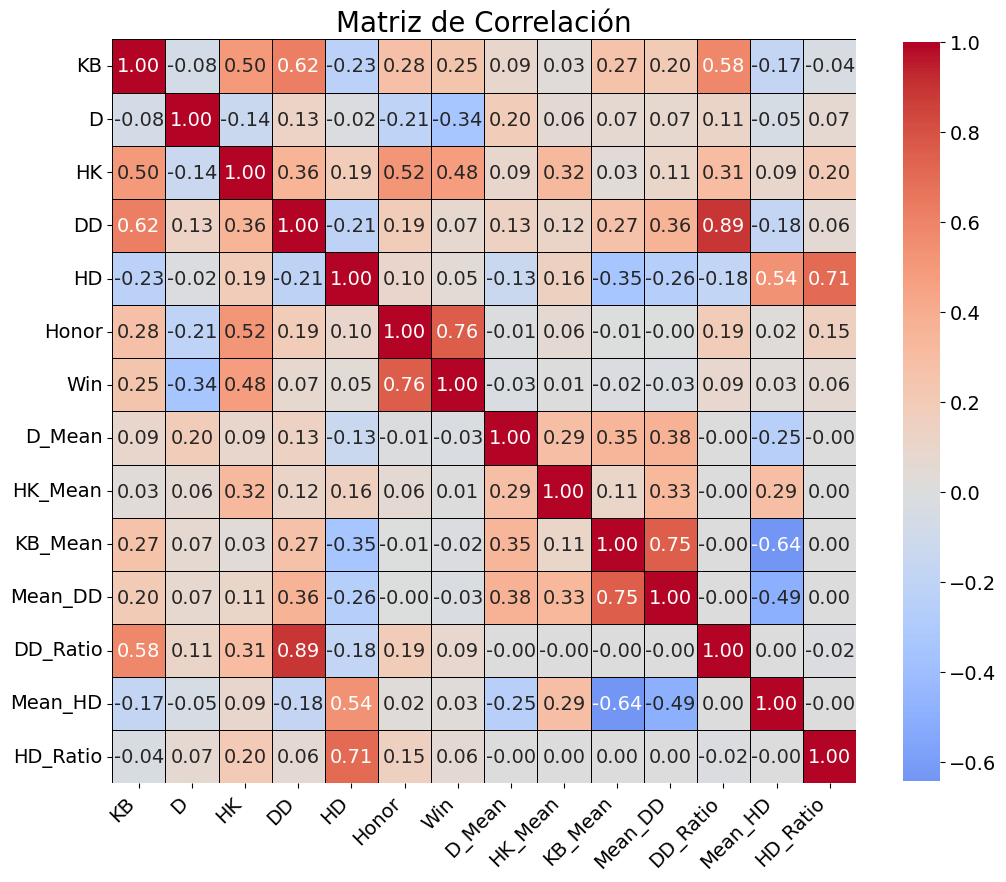

In [363]:
# Selecciona solo las columnas numéricas
numerical_df = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numerical_df.corr(method="pearson")

# Crea el mapa de calor
plt.figure(figsize=(12, 12))  # Ajusta el tamaño de la figura según sea necesario
sns.heatmap(correlation_matrix, 
            annot=True,             # Mostrar los valores de correlación
            fmt=".2f",             # Formato de los valores
            cmap='coolwarm',       # Paleta de colores
            center=0,              # Centrar la paleta en cero
            square=True,           # Hacer que cada celda sea cuadrada
            cbar_kws={"shrink": .8}, # Reducir el tamaño de la barra de color
            linewidths=.5,         # Añadir líneas entre las celdas
            linecolor='black'      # Color de las líneas
           )

# Títulos y etiquetas
plt.title('Matriz de Correlación', fontsize=20)
plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=0)               

#### Pairplot

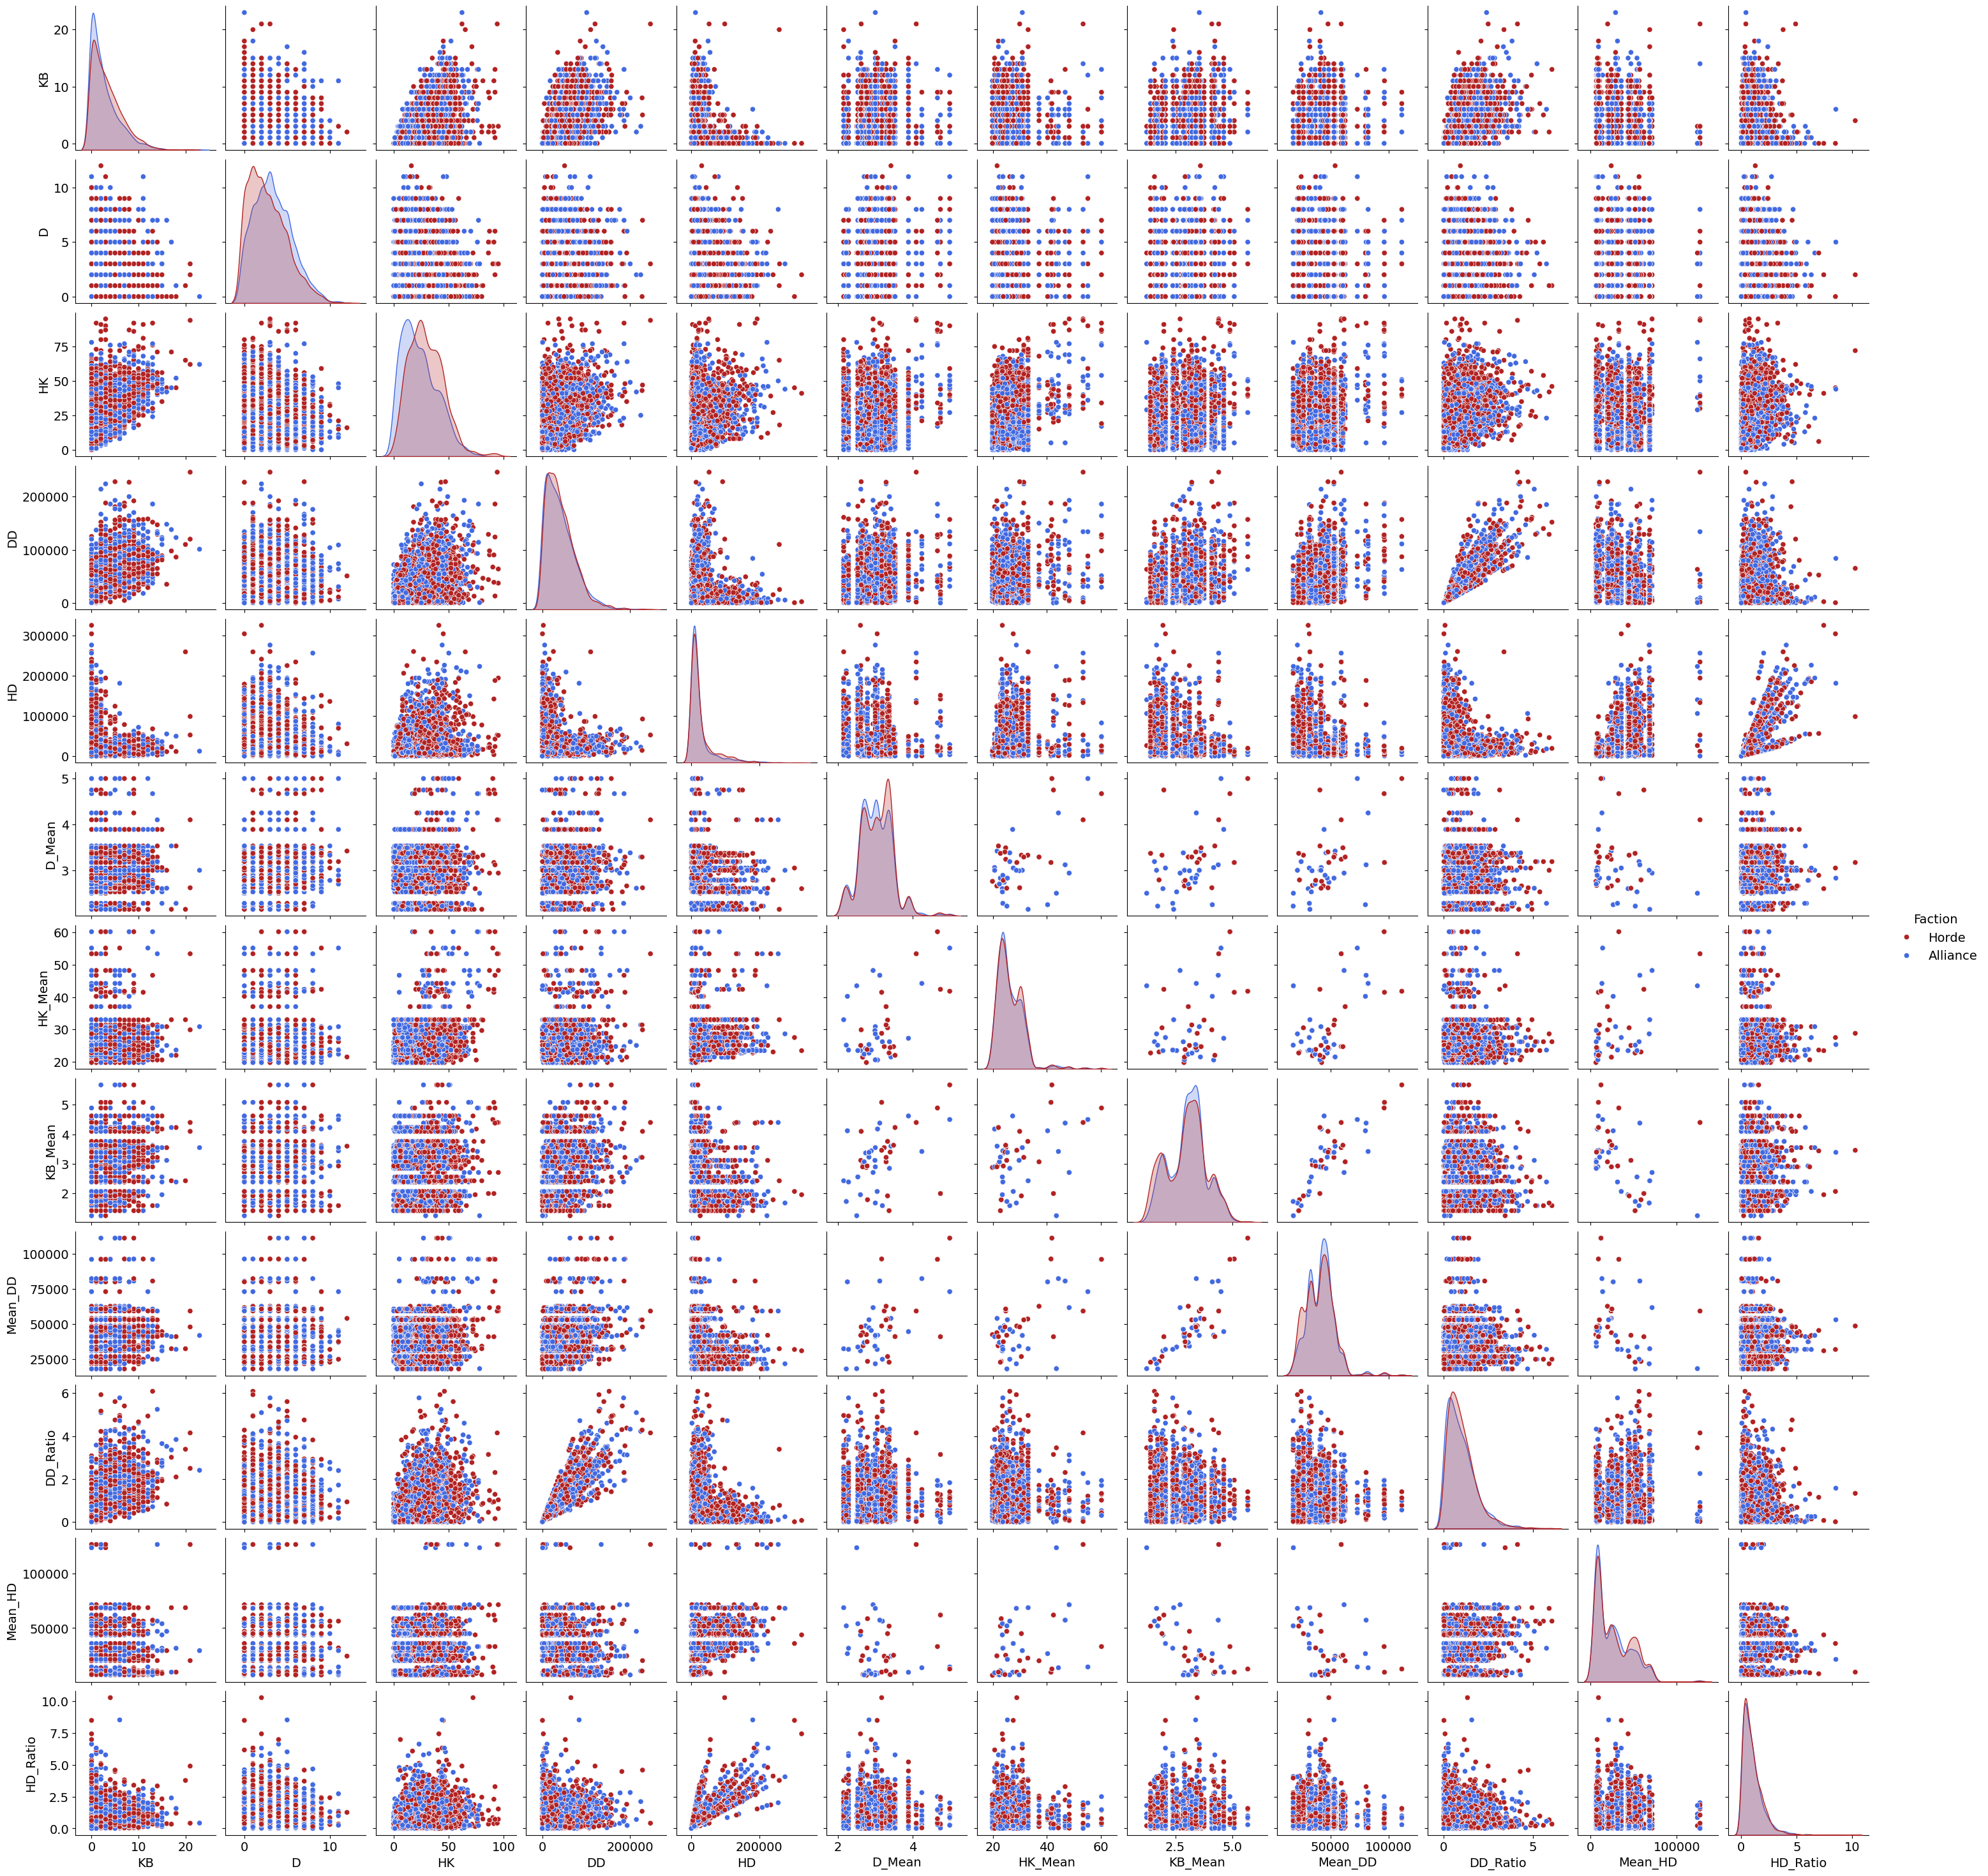

In [364]:
# Eliminamos las columnas "Honor" y "Win" (sin reasignar)
numerical_df = numerical_df.drop(columns=["Honor", "Win"])

# Añadimos la columna "Faction"
numerical_df["Faction"] = df["Faction"]

# Creamos un diccionario de colores personalizado
faction_colors = {'Alliance': 'royalblue', 'Horde': 'firebrick'}

# Visualizamos el parplot con la columna "Faction" como hue y el palette personalizado
sns.pairplot(numerical_df, hue="Faction", palette=faction_colors)


### Borramos variables continuas con alta correlación
- Quitamos HD y mantenemos HD_Ratio.
- Quitamos Honor y mantenemos Honor_Percentage.
- Quitamos DD y mantenemos DD_Ratio.

In [365]:
df = df.drop(columns=["DD","HD"])

## Selección de variables **Categoricas**.

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0, 0.5, 'Battleground'),
  Text(0, 1.5, 'Faction'),
  Text(0, 2.5, 'Class'),
  Text(0, 3.5, 'Rol'),
  Text(0, 4.5, 'Tipo_clase')])

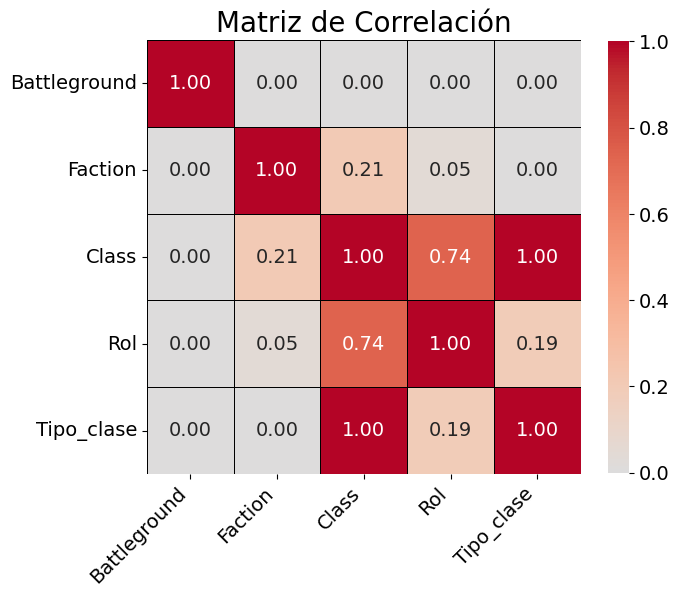

In [366]:
categorical_df = df.select_dtypes(include=["object"])

# Calcular la matriz de correlación usando phik
corr_matrix = categorical_df.phik_matrix()

# Crea el mapa de calor
plt.figure(figsize=(7, 7))  # Ajusta el tamaño de la figura según sea necesario
sns.heatmap(corr_matrix, 
            annot=True,             # Mostrar los valores de correlación
            fmt=".2f",             # Formato de los valores
            cmap='coolwarm',       # Paleta de colores
            center=0,              # Centrar la paleta en cero
            square=True,           # Hacer que cada celda sea cuadrada
            cbar_kws={"shrink": .8}, # Reducir el tamaño de la barra de color
            linewidths=.5,         # Añadir líneas entre las celdas
            linecolor='black'      # Color de las líneas
           )

# Títulos y etiquetas
plt.title('Matriz de Correlación', fontsize=20)
plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=0)  


#### Decido  borrar la variable **"Class"** ya que tiene  mucha correlación con **"Tipo_clase"** y si es necesario volvere a este punto para borrarla si veo necesario.

In [367]:
df = df.drop(columns="Class")

## Preparamos Features y Target.

In [368]:
df.columns
features = df[['Battleground', 'Faction', 'KB', 'D', 'HK', 'Rol',
       'Tipo_clase', 'D_Mean', 'HK_Mean', 'KB_Mean', 'Mean_DD', 'DD_Ratio',
       'Mean_HD', 'HD_Ratio',]] # 'Honor_Percentage', "Honor"
features

Battleground   Faction  KB  D  HK   Rol           Tipo_clase  D_Mean  \
0        Banderas     Horde   1  3  14   DPS  Hybrid_Ranged_melee    3.40   
1        Banderas     Horde   1  3  12   DPS                Melee    2.83   
2        Banderas  Alliance   0  1  19  HEAL                Melee    2.78   
3        Banderas  Alliance   1  2  25  HEAL                Melee    2.78   
4        Banderas  Alliance   2  3  23   DPS                Melee    2.70   
...           ...       ...  .. ..  ..   ...                  ...     ...   
3721     Banderas  Alliance  18  1  52   DPS  Hybrid_Ranged_melee    2.28   
3722     Banderas  Alliance   0  4  33   DPS  Hybrid_Ranged_melee    2.22   
3723     Banderas     Horde   2  5  28   DPS  Hybrid_Ranged_melee    3.40   
3724     Banderas  Alliance   2  5  41   DPS                Melee    2.83   
3725     Banderas  Alliance   6  5  44  HEAL  Hybrid_Ranged_melee    2.22   

      HK_Mean  KB_Mean   Mean_DD  DD_Ratio   Mean_HD  HD_Ratio  
0       24.42     3.40  47947.17  1.004335   7303.21  0.909326  
1       25.35     3.39  53111.88  0.508832  21251.04  0.334384  
2       23.82     2.93  37425.84  0.022017  31774.52  2.954537  
3       23.82     2.93  37425.84  0.188266  31774.52  3.103084  
4       22.38     3.07  36901.84  1.774519   6980.30  2.812057  
...       ...      ...       ...       ...       ...       ...  
3721    23.65     2.39  32028.74  3.840301  31499.22  1.571817  
3722    25.16     1.73  18115.88  0.722405  52031.96  0.174066  
3723    24.42     3.40  47947.17  1.196421   7303.21  0.936164  
3724    25.35     3.39  53111.88  0.847212  21251.04  1.926212  
3725    25.16     1.73  18115.88  4.716470  52031.96  2.037209  

[3726 rows x 14 columns]

#### Dividimos el dataset en conjunto de entrenamiento y de prueba.

In [369]:
X = pd.get_dummies(features, drop_first=True)
y = df['Win']

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [370]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3726 entries, 0 to 3725
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   KB                              3726 non-null   int64  
 1   D                               3726 non-null   int64  
 2   HK                              3726 non-null   int64  
 3   D_Mean                          3726 non-null   float64
 4   HK_Mean                         3726 non-null   float64
 5   KB_Mean                         3726 non-null   float64
 6   Mean_DD                         3726 non-null   float64
 7   DD_Ratio                        3726 non-null   float64
 8   Mean_HD                         3726 non-null   float64
 9   HD_Ratio                        3726 non-null   float64
 10  Battleground_Banderas_y_bases   3726 non-null   bool   
 11  Battleground_Defender_bases     3726 non-null   bool   
 12  Battleground_Otros              37

---
---
## LogisticRegression

In [371]:

modelo = LogisticRegression(solver = 'saga',
                                 random_state= 1234,
                                 penalty= "l2",
                                 C = 0.5,
                                 l1_ratio = 1)

modelo = LogisticRegression(random_state=42)
modelo.fit(X_train, y_train)

# Hacer predicciones
y_pred = modelo.predict(X_test)
y_pred_proba = modelo.predict_proba(X_test)  # Para probabilidades

c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Parametros del modelo

In [372]:
# Obtener los parámetros del modelo
params = modelo.get_params()

# Imprimir los parámetros en formato vertical
for key, value in params.items():
    print(f"{key}: {value}")

C: 1.0
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 100
multi_class: deprecated
n_jobs: None
penalty: l2
random_state: 42
solver: lbfgs
tol: 0.0001
verbose: 0
warm_start: False


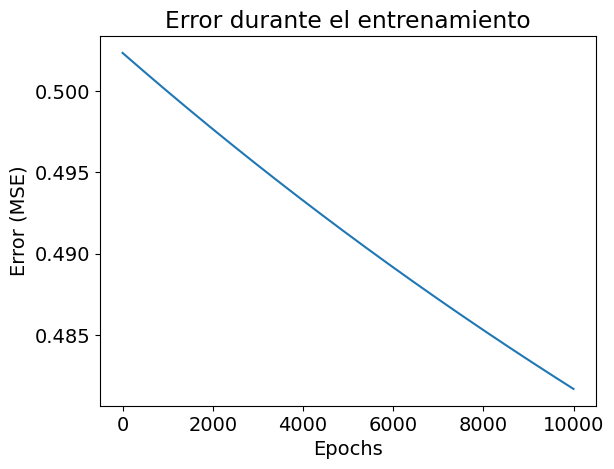

In [373]:
# Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

def gradient_descent(learning_rate, epochs):
    m = len(y)  # Número de muestras
    W = np.random.normal(0, 0.01, size=X_scaled.shape[1])  # Inicialización de los pesos
    total_error = []

    for epoch in range(epochs):
        # Predicciones
        y_pred = X_scaled.dot(W)

        # Cálculo del error (por ejemplo, MSE)
        error = y_pred - y
        mse = (error ** 2).mean()
        total_error.append(mse)

        # Gradiente
        gradient = X_scaled.T.dot(error) / m

        # Actualización de pesos
        W -= learning_rate * gradient

    return total_error, epoch

# Configuración del aprendizaje y número de épocas
learning_rate = 0.00001  # Ajustar la tasa de aprendizaje
epochs = 10000

# Ejecutar descenso de gradiente
total_error, finalepoch = gradient_descent(learning_rate, epochs)

# Graficar el error
plt.plot(range(len(total_error)), total_error)
plt.xlabel("Epochs")
plt.ylabel("Error (MSE)")
plt.title("Error durante el entrenamiento")
plt.show()


#### Intercepto

In [374]:
print("\nIntercepto:", modelo.intercept_[0])


Intercepto: 0.00160259394615421


#### Coeficientes

In [375]:
# Ver los coeficientes para cada categoría
print("\nCoeficientes para cada categoría:")
for categoria, coef in zip(X.columns, modelo.coef_[0]):
    print(f"{categoria}: {coef:.3f}")


Coeficientes para cada categoría:
KB: -0.012
D: -0.352
HK: 0.089
D_Mean: -0.001
HK_Mean: -0.047
KB_Mean: 0.010
Mean_DD: 0.000
DD_Ratio: -0.040
Mean_HD: -0.000
HD_Ratio: -0.026
Battleground_Banderas_y_bases: -0.015
Battleground_Defender_bases: 0.013
Battleground_Otros: -0.001
Faction_Horde: 0.090
Rol_HEAL: 0.002
Tipo_clase_Hybrid_Ranged_melee: -0.011
Tipo_clase_Melee: 0.017


### Preb proba en porcentajes y con umbral modificado a 0.8

In [376]:
umbral = 0.5
y_pred_custom = (y_pred_proba[:, 1] >= umbral).astype(int)

# Formatear las primeras 5 probabilidades predichas en porcentajes
print("\nPrimeras 5 probabilidades predichas (en porcentajes):")
for i, prob in enumerate(y_pred_proba[:10]):
    print(f"[{prob[0] * 100:.2f}%, {prob[1] * 100:.2f}%]")


Primeras 5 probabilidades predichas (en porcentajes):
[11.23%, 88.77%]
[64.09%, 35.91%]
[13.05%, 86.95%]
[91.02%, 8.98%]
[62.01%, 37.99%]
[34.72%, 65.28%]
[31.45%, 68.55%]
[63.84%, 36.16%]
[30.44%, 69.56%]
[20.08%, 79.92%]


#### Evaluación del modelo:

In [377]:
# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Sensibilidad (recall)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])

# Especificidad
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

# F1 Score
f1 = f1_score(y_test, y_pred)

# Aplicar validación cruzada
scores = cross_val_score(modelo, X, y, cv=5)  # Ajusta el número de folds según necesites
print(f"Scores de validación cruzada: {scores}")
print(f"Media de scores: {scores.mean()}")

# Imprimir resultados
print(f"\nLogisticRegression accuracy is {accuracy:.3f}")
print(f"LogisticRegression Sensitivity is {sensitivity:.3f}")
print(f"LogisticRegression Specificity is {specificity:.3f}")
print(f"LogisticRegression F1 is {f1:.3f}")

# Mostrar el reporte de clasificación para el conjunto de test
print("\nClassification Report for Test Set:")
print(classification_report(y_test, y_pred))


Scores de validación cruzada: [0.81099196 0.73288591 0.70604027 0.74630872 0.86711409]
Media de scores: 0.7726681900786296

LogisticRegression accuracy is 0.779
LogisticRegression Sensitivity is 0.763
LogisticRegression Specificity is 0.797
LogisticRegression F1 is 0.784

Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.75      0.80      0.77       354
           1       0.81      0.76      0.78       392

    accuracy                           0.78       746
   macro avg       0.78      0.78      0.78       746
weighted avg       0.78      0.78      0.78       746



c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

### Cross validation

Media de CV scores : 0.7726681900786296


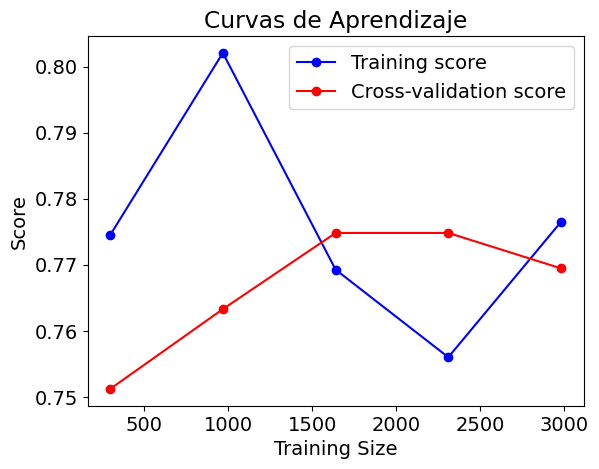

In [378]:
train_sizes, train_scores, test_scores = learning_curve(modelo, X, y, cv=5, n_jobs=-1)

# Promedia los scores para cada tamaño de conjunto de entrenamiento
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

print(f"Media de CV scores : {scores.mean()}")

plt.plot(train_sizes, train_scores_mean, label="Training score",marker="o", color="blue")
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score",marker="o", color="red")
plt.xlabel("Training Size")
plt.ylabel("Score")
plt.title("Curvas de Aprendizaje")
plt.legend()
plt.show()


#### Matriz de confución

Métricas detalladas:
Verdaderos Negativos (TN): 282
Falsos Positivos (FP): 72
Falsos Negativos (FN): 93
Verdaderos Positivos (TP): 299


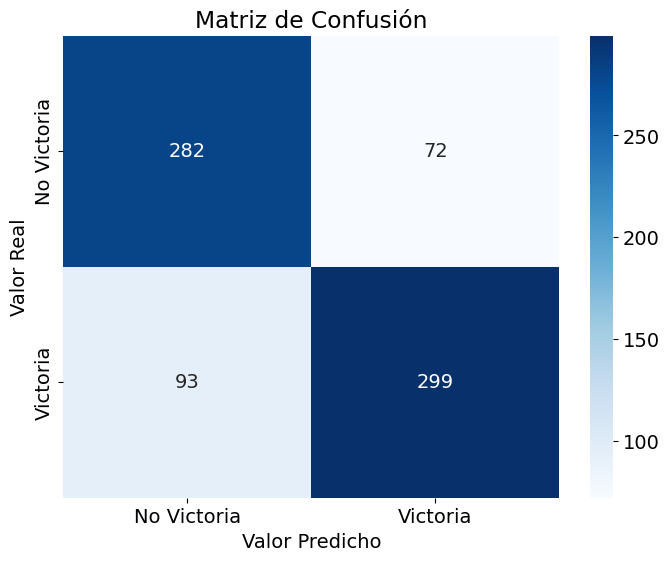

In [379]:
#Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Calcular métricas específicas de la matriz de confusión
tn, fp, fn, tp = conf_matrix.ravel()
print("Métricas detalladas:")
print(f"Verdaderos Negativos (TN): {tn}")
print(f"Falsos Positivos (FP): {fp}")
print(f"Falsos Negativos (FN): {fn}")
print(f"Verdaderos Positivos (TP): {tp}")

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Victoria', 'Victoria'],
            yticklabels=['No Victoria', 'Victoria'])
plt.title('Matriz de Confusión')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predicho')
plt.show()

#### Calculamos el **"AUC_TRAIN"** y **"AUC_TEST"**

In [380]:
# Obtener las probabilidades de predicción para el conjunto de entrenamiento
y_prob_train = modelo.predict_proba(X_train)

# Calcular el AUC para el conjunto de entrenamiento
auc_train = roc_auc_score(y_train, y_prob_train[:, 1])

# Calcular el AUC para el conjunto de prueba (ya lo tienes)
y_prob_test = modelo.predict_proba(X_test)
auc_test = roc_auc_score(y_test, y_prob_test[:, 1])


#### Visualizamos **"ROC CURVE"** y **"AUC"**

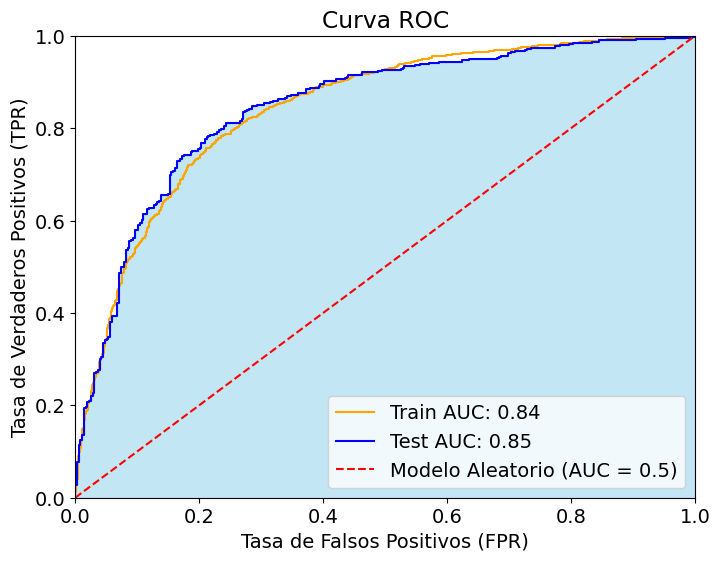

LogisticRegression accuracy is 0.779
LogisticRegression auc in train is 0.842
LogisticRegression auc in test is 0.845
LogisticRegression Sensitivity is 0.763
LogisticRegression Specificity is 0.797
LogisticRegression F1 is 0.784


In [381]:
# Visualizar la curva ROC para el conjunto de entrenamiento
plt.figure(figsize=(8, 6))
fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train[:, 1])  # Obtener valores FPR y TPR para entrenamiento
plt.plot(fpr_train, tpr_train, label=f'Train AUC: {auc_train:.2f}', color='orange')

# Visualizar la curva ROC para el conjunto de prueba
fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test[:, 1])  # Obtener valores FPR y TPR para prueba
plt.plot(fpr_test, tpr_test, label=f'Test AUC: {auc_test:.2f}', color='blue')

# Trazar la diagonal (modelo aleatorio)
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Modelo Aleatorio (AUC = 0.5)')

# Rellenar el área bajo la curva ROC para el conjunto de prueba
plt.fill_between(fpr_test, tpr_test, color='skyblue', alpha=0.5)

# Ajustar etiquetas y título
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc='lower right')
plt.show()

#Imprimimos todos las metricas
print(f"LogisticRegression accuracy is {accuracy:.3f}")
print(f"LogisticRegression auc in train is {auc_train:.3f}")
print(f"LogisticRegression auc in test is {auc_test:.3f}")
print(f"LogisticRegression Sensitivity is {sensitivity:.3f}")
print(f"LogisticRegression Specificity is {specificity:.3f}")
print(f"LogisticRegression F1 is {f1:.3f}")

---
--- 
## KNeighborsClassifier

#### Entrenamos el modelo **""KNeighborsClassifier""**

In [382]:
# Define el modelo
knn_model = KNeighborsClassifier(n_neighbors=13,
                                 metric="hamming",
                                 weights="uniform")

# Realizar la validación cruzada
scores = cross_val_score(knn_model, X_train, y_train, cv=5)

# Imprimir los resultados
print("Puntuaciones de la validación cruzada:", scores)
print("Precisión media de la validación cruzada:", np.mean(scores))

# Entrenar el modelo en todo el conjunto de entrenamiento
knn_model.fit(X_train, y_train)

# Hacer predicciones
# Hacer predicciones
y_pred = knn_model.predict(X_test)

Puntuaciones de la validación cruzada: [0.68120805 0.66610738 0.66107383 0.68120805 0.66610738]
Precisión media de la validación cruzada: 0.6711409395973155


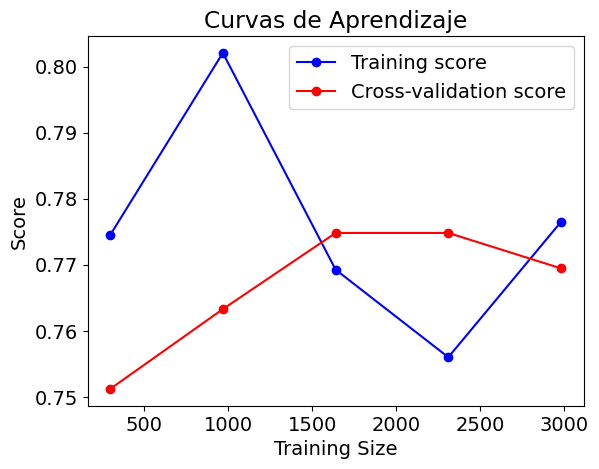

In [383]:
train_sizes, train_scores, test_scores = learning_curve(modelo, X, y, cv=5, n_jobs=-1)

# Promedia los scores para cada tamaño de conjunto de entrenamiento
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label="Training score",marker="o", color="blue")
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score",marker="o", color="red")
plt.xlabel("Training Size")
plt.ylabel("Score")
plt.title("Curvas de Aprendizaje")
plt.legend()
plt.show()


#### Evaluación del modelo:

In [384]:
# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Sensibilidad (recall)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])

# Especificidad
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

# F1 Score
f1 = f1_score(y_test, y_pred)

# Imprimir resultados
print(f"KNeighborsClassifier accuracy is {accuracy:.3f}")
print(f"KNeighborsClassifier Sensitivity is {sensitivity:.3f}")
print(f"KNeighborsClassifier Specificity is {specificity:.3f}")
print(f"KNeighborsClassifier F1 is {f1:.3f}")

# Mostrar el reporte de clasificación para el conjunto de test
print("\nClassification Report for Test Set:")
print(classification_report(y_test, y_pred))

KNeighborsClassifier accuracy is 0.681
KNeighborsClassifier Sensitivity is 0.663
KNeighborsClassifier Specificity is 0.701
KNeighborsClassifier F1 is 0.686

Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.65      0.70      0.68       354
           1       0.71      0.66      0.69       392

    accuracy                           0.68       746
   macro avg       0.68      0.68      0.68       746
weighted avg       0.68      0.68      0.68       746



#### Graficar el error rate para ver cuando llega ala zona de equilibrio

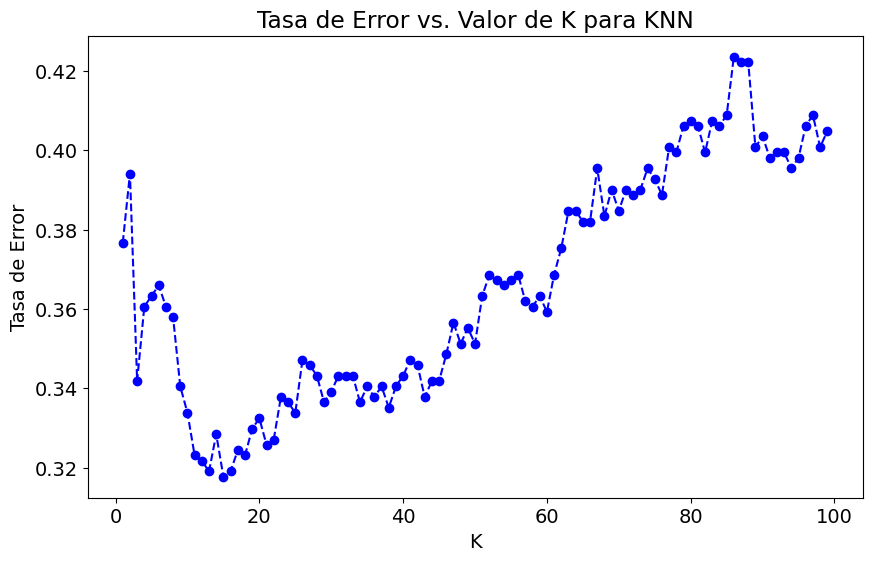

K  Error Rate
14  15    0.317694
15  16    0.319035
12  13    0.319035
11  12    0.321716
10  11    0.323056
17  18    0.323056
16  17    0.324397
20  21    0.325737
21  22    0.327078
13  14    0.328418

In [385]:
# Lista para almacenar la tasa de error para cada valor de K
error_rate = []

# Asegurarnos de que y_test es binario (0 y 1)
y_test_bin = y_test.astype(int)

# Probar valores de K en un rango (por ejemplo, de 1 a 40)
for i in range(1, 100):
    knn = KNeighborsClassifier(n_neighbors=i, metric='hamming', weights='uniform')
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test).astype(int)  # Convertir a int si es necesario
    error_rate.append(1 - accuracy_score(y_test_bin, pred_i))  # Calcular tasa de error

# Graficar la tasa de error en función de K
plt.figure(figsize=(10, 6))
plt.plot(range(1, 100), error_rate, color='blue', linestyle='dashed', marker='o')
plt.xlabel('K')
plt.ylabel('Tasa de Error')
plt.title('Tasa de Error vs. Valor de K para KNN')
plt.show()
error_df = pd.DataFrame({'K': range(1, 100), 'Error Rate': error_rate})

error_df = error_df.sort_values(by="Error Rate",ascending=True)
error_df.head(10)

#### Filtrando duplicados podemos encontrar zonas de equlibrio con el menor rate lo que conmvierte es **"K"** en un buen candidato.

In [386]:
# Filtrar los valores duplicados en la columna "Error Rate"
duplicados = error_df[error_df["Error Rate"].duplicated(keep=False)].sort_values(by="Error Rate")

duplicados.head(10)

K  Error Rate
15  16    0.319035
12  13    0.319035
10  11    0.323056
17  18    0.323056
9   10    0.333780
24  25    0.333780
33  34    0.336461
23  24    0.336461
28  29    0.336461
22  23    0.337802

#### Matriz de confusión 

Métricas detalladas:
Verdaderos Negativos (TN): 248
Falsos Positivos (FP): 106
Falsos Negativos (FN): 132
Verdaderos Positivos (TP): 260


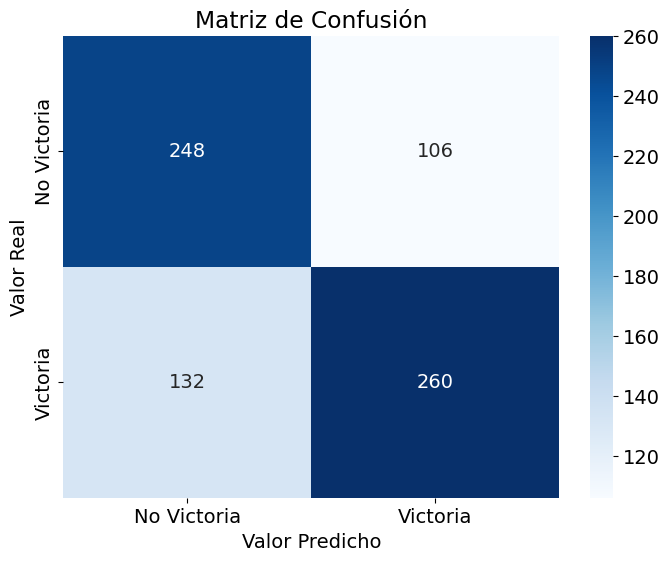

In [387]:
#Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Calcular métricas específicas de la matriz de confusión
tn, fp, fn, tp = conf_matrix.ravel()
print("Métricas detalladas:")
print(f"Verdaderos Negativos (TN): {tn}")
print(f"Falsos Positivos (FP): {fp}")
print(f"Falsos Negativos (FN): {fn}")
print(f"Verdaderos Positivos (TP): {tp}")

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Victoria', 'Victoria'],
            yticklabels=['No Victoria', 'Victoria'])
plt.title('Matriz de Confusión')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predicho')
plt.show()

#### Calculamos el **"AUC_TRAIN"** y **"AUC_TEST"**

In [388]:
# Obtener las probabilidades de predicción para el conjunto de entrenamiento
y_prob_train = knn_model.predict_proba(X_train)

# Calcular el AUC para el conjunto de entrenamiento
auc_train = roc_auc_score(y_train, y_prob_train[:, 1])

# Calcular el AUC para el conjunto de prueba (ya lo tienes)
y_prob_test = knn_model.predict_proba(X_test)
auc_test = roc_auc_score(y_test, y_prob_test[:, 1])

#### Visualizamos **"ROC CURVE"** y **"AUC"**

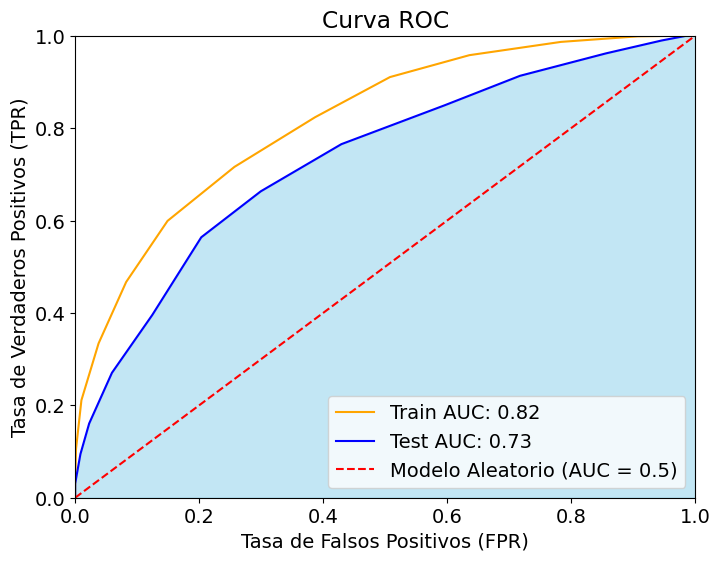

KNeighborsClassifier accuracy is 0.681
KNeighborsClassifier auc in train is 0.817
KNeighborsClassifier auc in test is 0.735
KNeighborsClassifier Sensitivity is 0.663
KNeighborsClassifier Specificity is 0.701
KNeighborsClassifier F1 is 0.686


In [389]:
# Visualizar la curva ROC para el conjunto de entrenamiento
plt.figure(figsize=(8, 6))
fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train[:, 1])  # Obtener valores FPR y TPR para entrenamiento
plt.plot(fpr_train, tpr_train, label=f'Train AUC: {auc_train:.2f}', color='orange')

# Visualizar la curva ROC para el conjunto de prueba
fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test[:, 1])  # Obtener valores FPR y TPR para prueba
plt.plot(fpr_test, tpr_test, label=f'Test AUC: {auc_test:.2f}', color='blue')

# Trazar la diagonal (modelo aleatorio)
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Modelo Aleatorio (AUC = 0.5)')

# Rellenar el área bajo la curva ROC para el conjunto de prueba
plt.fill_between(fpr_test, tpr_test, color='skyblue', alpha=0.5)

# Ajustar etiquetas y título
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc='lower right')
plt.show()

#Imprimimos todos las metricas
print(f"KNeighborsClassifier accuracy is {accuracy:.3f}")
print(f"KNeighborsClassifier auc in train is {auc_train:.3f}")
print(f"KNeighborsClassifier auc in test is {auc_test:.3f}")
print(f"KNeighborsClassifier Sensitivity is {sensitivity:.3f}")
print(f"KNeighborsClassifier Specificity is {specificity:.3f}")
print(f"KNeighborsClassifier F1 is {f1:.3f}")

#### Utilizamos metodo de **permutación** para entender las variables mas importantes del modelo

In [390]:
# Calcula la importancia de permutación (Por cada n_repeats esta tardando 1 minuto de media)
results = permutation_importance(knn_model, X_test, y_test, n_repeats=5, random_state=42)

# Crear un DataFrame para visualizar
importances = pd.DataFrame(results.importances_mean, index=X_test.columns, columns=['Importance']).sort_values('Importance', ascending=False)

#### Resultados de las 10 variables con mayor importancia del modelo

In [391]:
top_features = importances.sort_values(by="Importance", ascending=False).head(10)
top_features

Importance
Faction_Horde       0.130563
D                   0.050938
KB                  0.029223
HK                  0.020107
HK_Mean             0.019839
Mean_DD             0.018767
Mean_HD             0.018767
D_Mean              0.018767
KB_Mean             0.018231
Tipo_clase_Melee    0.011260

C:\Users\Usuario\AppData\Local\Temp\ipykernel_3972\3484175958.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features["Importance"], y=top_features.index,edgecolor="black", palette="viridis")


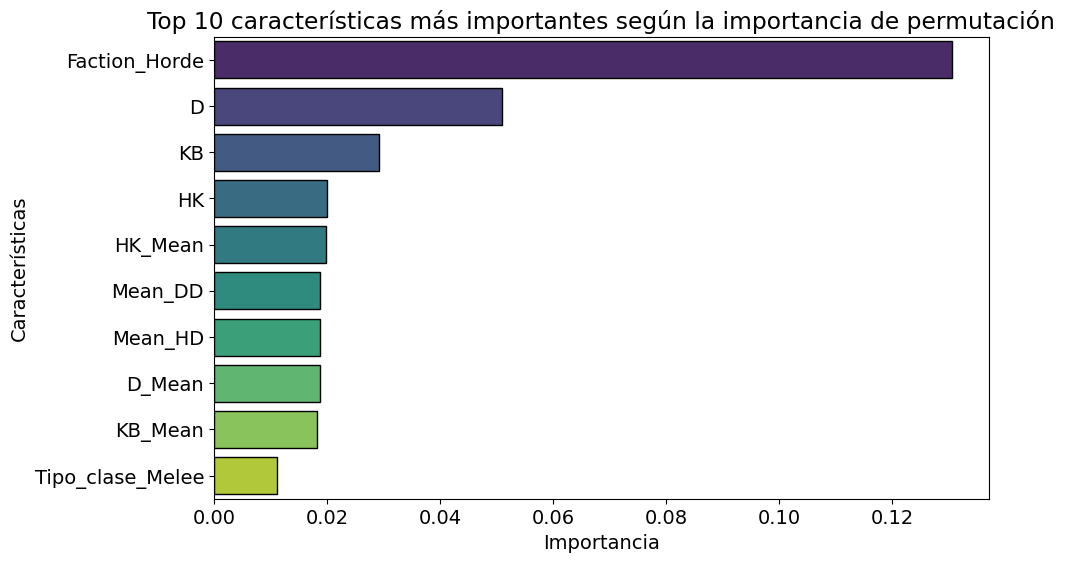

In [392]:
# Crear gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=top_features["Importance"], y=top_features.index,edgecolor="black", palette="viridis")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.title("Top 10 características más importantes según la importancia de permutación")
plt.show()


----
----

## DecisionTreeClassifier

### Param grid

In [393]:
# # Definir el rango de hiperparámetros
# param_grid = {
#     'criterion': ['gini', 'entropy'],  # Probar 'gini' y 'entropy'
#     'max_depth': [3, 4, 5, 6, 7, 8, 10],  # Rango de profundidad del árbol
#     'min_samples_split': [10, 30, 70,90],  # Número mínimo de muestras para dividir un nodo
#     'min_samples_leaf': [70, 85, 90, 100],  # Número mínimo de muestras en una hoja
#     "max_leaf_nodes": [15,20,25,30],  # 
# }

# # Configurar la búsqueda de hiperparámetros
# grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42,class_weight='balanced'),
#                            param_grid,
#                            cv=5,  # Número de pliegues para la validación cruzada
#                            n_jobs=-1,  # Usar todos los núcleos disponibles
#                            verbose=1)

# # Entrenar la búsqueda de hiperparámetros
# grid_search.fit(X_train, y_train)

# # Mejor modelo encontrado
# arbol = grid_search.best_estimator_
# # print("Mejores hiperparámetros:", grid_search.best_params_)

#### Entrenamiento del modelo

In [394]:
#Arbol
arbol = DecisionTreeClassifier(random_state=42,
                               criterion= "gini",
                               class_weight='balanced',
                               max_depth=None,
                               max_leaf_nodes=15,
                               min_samples_split=15,
                               min_samples_leaf=30)
                    
# Entrenar el modelo
arbol.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = arbol.predict(X_test)
# Crear un reporte sobre el árbol

scores = cross_val_score(arbol, X_train, y_train, cv=5)
n_nodes = arbol.tree_.node_count
n_leaves = arbol.tree_.n_leaves
max_depth = arbol.get_depth()

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [395]:
report = f"""
Reporte del Árbol de Decisión:
-------------------------------
Profundidad máxima del árbol: {max_depth}
Número de nodos en el árbol: {n_nodes}
Número de hojas en el árbol: {n_leaves}

Tasa de error (Entrenamiento): {1 - accuracy_score(y_train, arbol.predict(X_train)):.3f}
Tasa de error (Prueba): {1 - accuracy_score(y_test, arbol.predict(X_test)):.3f}

Puntuaciones de la validación cruzada: {scores}
Precisión media de la validación cruzada: {np.mean(scores):.3f}

Parámetros del modelo:
-----------------------
- min_samples_split: {arbol.min_samples_split}
- min_samples_leaf: {arbol.min_samples_leaf}
- max_features: {arbol.max_features}

"""

# Imprimir el reporte
print(report)



Reporte del Árbol de Decisión:
-------------------------------
Profundidad máxima del árbol: 5
Número de nodos en el árbol: 29
Número de hojas en el árbol: 15

Tasa de error (Entrenamiento): 0.213
Tasa de error (Prueba): 0.217

Puntuaciones de la validación cruzada: [0.76845638 0.76677852 0.74496644 0.76174497 0.77684564]
Precisión media de la validación cruzada: 0.764

Parámetros del modelo:
-----------------------
- min_samples_split: 15
- min_samples_leaf: 30
- max_features: None




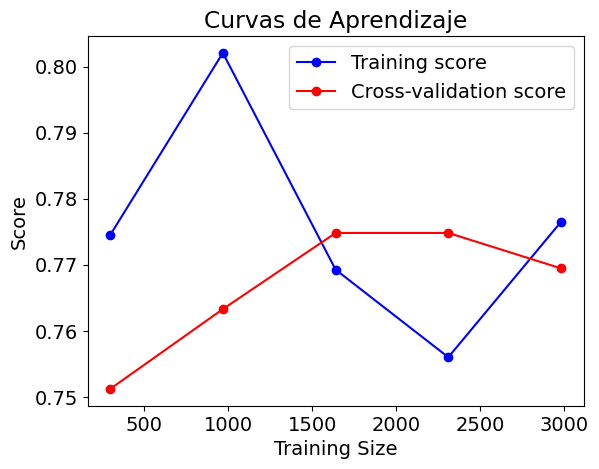

In [396]:
train_sizes, train_scores, test_scores = learning_curve(modelo, X, y, cv=5, n_jobs=-1)

# Promedia los scores para cada tamaño de conjunto de entrenamiento
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label="Training score",marker="o", color="blue")
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score",marker="o", color="red")
plt.xlabel("Training Size")
plt.ylabel("Score")
plt.title("Curvas de Aprendizaje")
plt.legend()
plt.show()


### Visualización del árbol

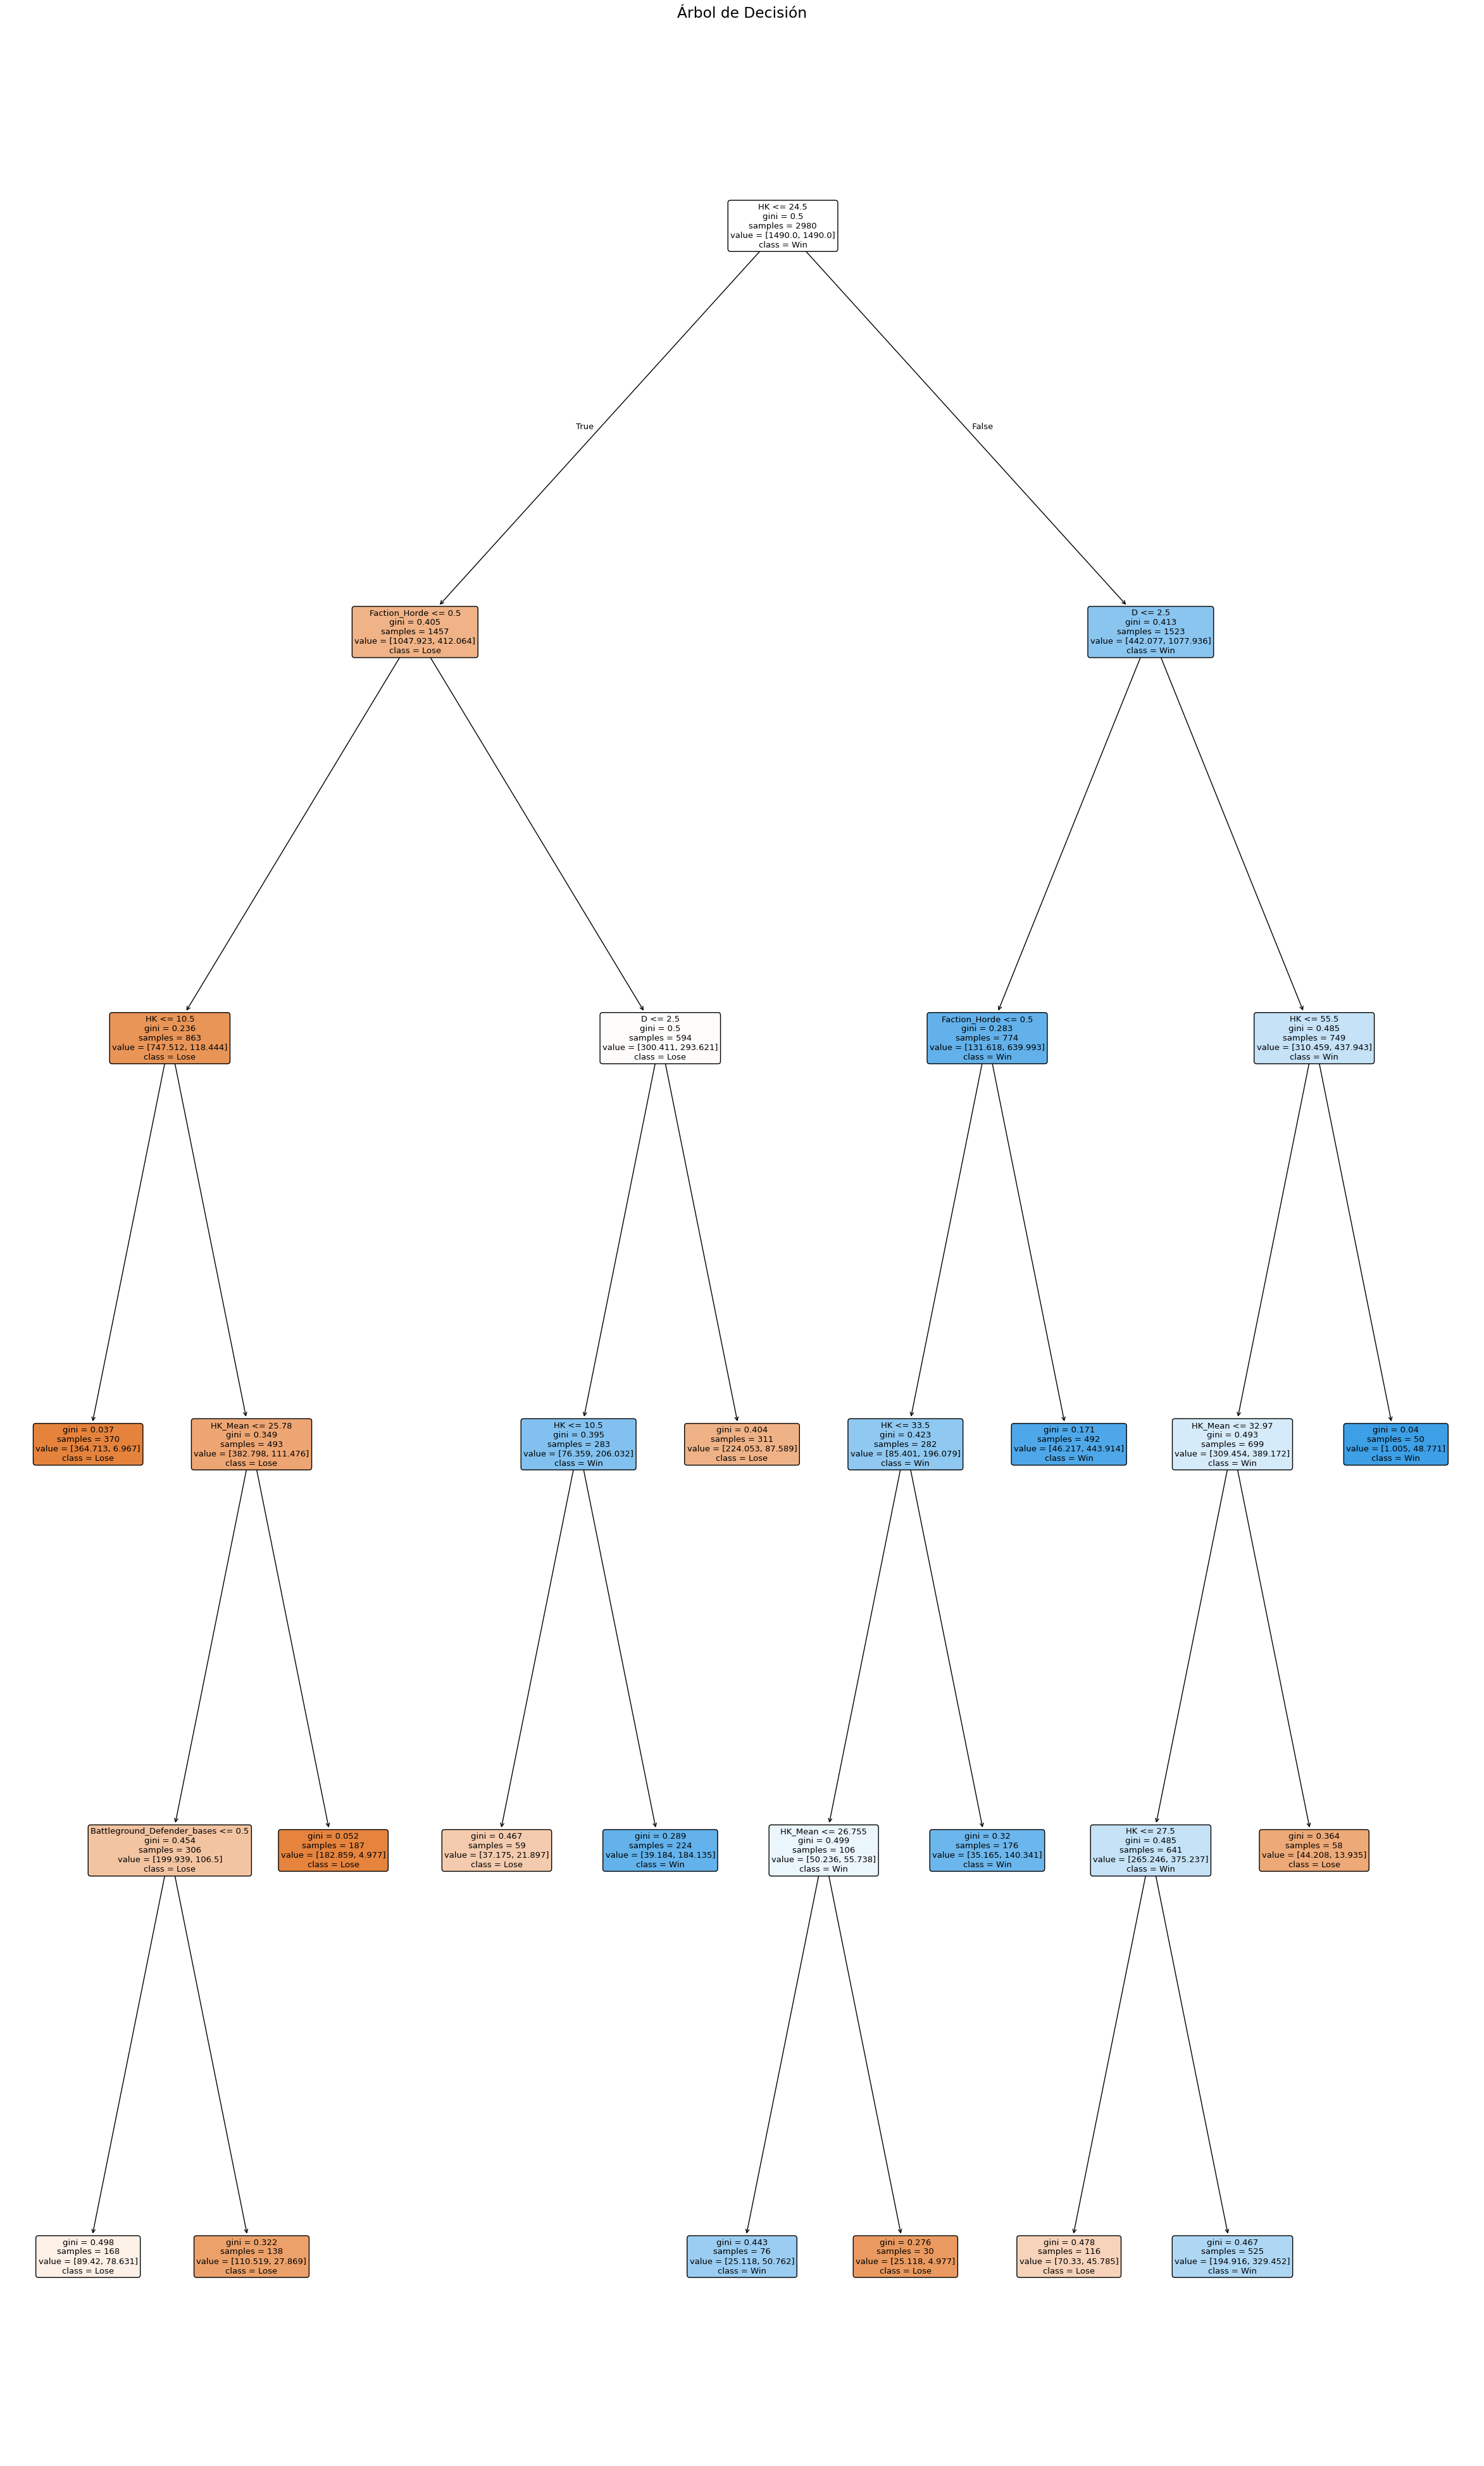

In [397]:
plt.figure(figsize=(30, 50))  # Ajustar dpi para mejorar resolución
plot_tree(arbol, filled=True, feature_names=X.columns, class_names=['Lose', 'Win'], rounded=True)
plt.title('Árbol de Decisión')
plt.show()

#### Resultados del modelo

In [398]:
# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Sensibilidad (recall)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])

# Especificidad
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

# F1 Score
f1 = f1_score(y_test, y_pred)

# Imprimir resultados
print(f"DecisionTreeClassifier accuracy is {accuracy:.3f}")
print(f"DecisionTreeClassifier Sensitivity is {sensitivity:.3f}")
print(f"DecisionTreeClassifier Specificity is {specificity:.3f}")
print(f"DecisionTreeClassifier F1 is {f1:.3f}")

# Mostrar el reporte de clasificación para el conjunto de test
print("\nClassification Report for Test Set:")
print(classification_report(y_test, y_pred))

DecisionTreeClassifier accuracy is 0.783
DecisionTreeClassifier Sensitivity is 0.783
DecisionTreeClassifier Specificity is 0.782
DecisionTreeClassifier F1 is 0.791

Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.77      0.78      0.77       354
           1       0.80      0.78      0.79       392

    accuracy                           0.78       746
   macro avg       0.78      0.78      0.78       746
weighted avg       0.78      0.78      0.78       746



#### Matriz de confusión

Métricas detalladas:
Verdaderos Negativos (TN): 277
Falsos Positivos (FP): 77
Falsos Negativos (FN): 85
Verdaderos Positivos (TP): 307


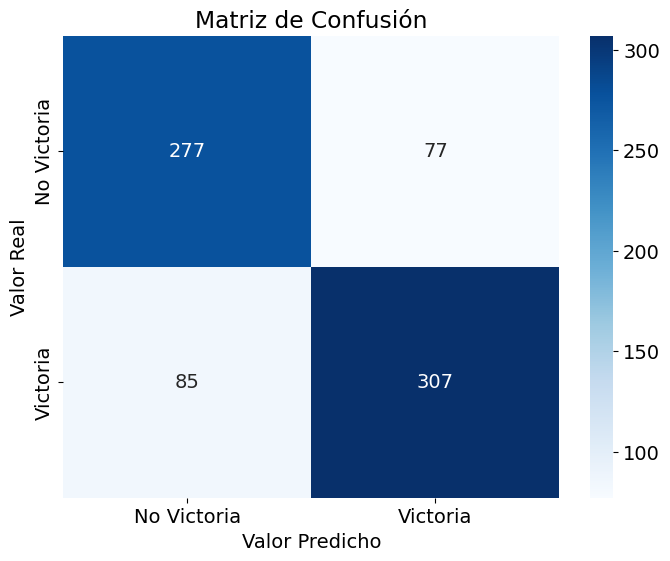

In [399]:
#Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Calcular métricas específicas de la matriz de confusión
tn, fp, fn, tp = conf_matrix.ravel()
print("Métricas detalladas:")
print(f"Verdaderos Negativos (TN): {tn}")
print(f"Falsos Positivos (FP): {fp}")
print(f"Falsos Negativos (FN): {fn}")
print(f"Verdaderos Positivos (TP): {tp}")

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Victoria', 'Victoria'],
            yticklabels=['No Victoria', 'Victoria'])
plt.title('Matriz de Confusión')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predicho')
plt.show()

#### Calculamos el **"AUC_TRAIN"** y **"AUC_TEST"**

In [400]:
# Obtener las probabilidades de predicción para el conjunto de entrenamiento
y_prob_train = arbol.predict_proba(X_train)

# Calcular el AUC para el conjunto de entrenamiento
auc_train = roc_auc_score(y_train, y_prob_train[:, 1])

# Calcular el AUC para el conjunto de prueba (ya lo tienes)
y_prob_test = arbol.predict_proba(X_test)
auc_test = roc_auc_score(y_test, y_prob_test[:, 1])

#### Visualizamos **"ROC CURVE"** y **"AUC"**

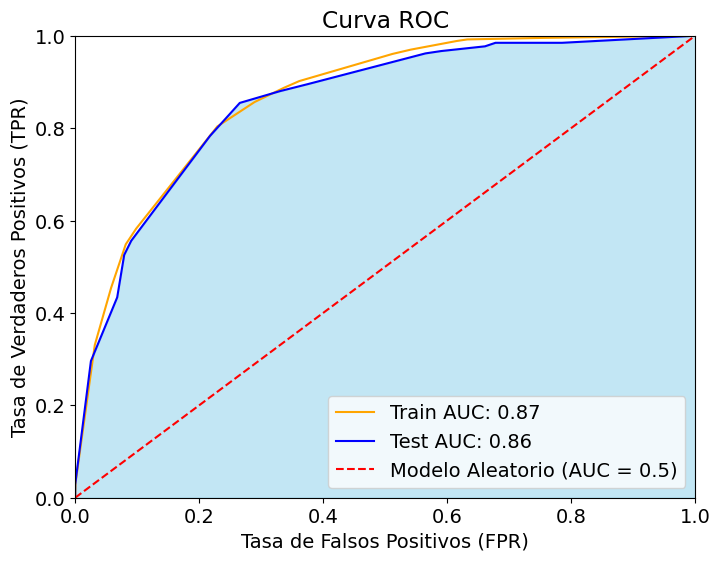

DecisionTreeClassifier accuracy is 0.783
DecisionTreeClassifier auc in train is 0.865
DecisionTreeClassifier auc in test is 0.856
DecisionTreeClassifier Sensitivity is 0.783
DecisionTreeClassifier Specificity is 0.782
DecisionTreeClassifier F1 is 0.791


In [401]:
# Visualizar la curva ROC para el conjunto de entrenamiento
plt.figure(figsize=(8, 6))
fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train[:, 1])  # Obtener valores FPR y TPR para entrenamiento
plt.plot(fpr_train, tpr_train, label=f'Train AUC: {auc_train:.2f}', color='orange')

# Visualizar la curva ROC para el conjunto de prueba
fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test[:, 1])  # Obtener valores FPR y TPR para prueba
plt.plot(fpr_test, tpr_test, label=f'Test AUC: {auc_test:.2f}', color='blue')

# Trazar la diagonal (modelo aleatorio)
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Modelo Aleatorio (AUC = 0.5)')

# Rellenar el área bajo la curva ROC para el conjunto de prueba
plt.fill_between(fpr_test, tpr_test, color='skyblue', alpha=0.5)

# Ajustar etiquetas y título
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc='lower right')
plt.show()

#Imprimimos todos las metricas
print(f"DecisionTreeClassifier accuracy is {accuracy:.3f}")
print(f"DecisionTreeClassifier auc in train is {auc_train:.3f}")
print(f"DecisionTreeClassifier auc in test is {auc_test:.3f}")
print(f"DecisionTreeClassifier Sensitivity is {sensitivity:.3f}")
print(f"DecisionTreeClassifier Specificity is {specificity:.3f}")
print(f"DecisionTreeClassifier F1 is {f1:.3f}")

### Variables importantes del modelo.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_3972\3299661265.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis', edgecolor="black")


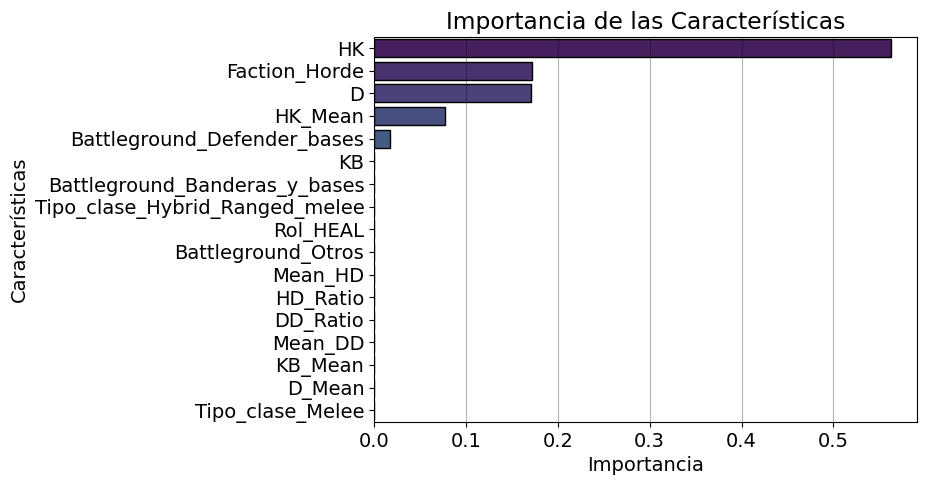

Feature  Importance
2                            HK     0.56231
13                Faction_Horde     0.17190
1                             D     0.17067
4                       HK_Mean     0.07759
11  Battleground_Defender_bases     0.01753

In [402]:
# Obtener las importancias de las características
importances = arbol.feature_importances_

# Crear un DataFrame con características y sus importancias
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Ordenar el DataFrame por importancia
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualizar la importancia de las características con Seaborn
plt.figure(figsize=(7, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis', edgecolor="black")
plt.title("Importancia de las Características")
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.grid(alpha=0.3, color="black", axis="x")
plt.show()

feature_importance_df = feature_importance_df.round(5).sort_values(by="Importance", ascending=False)
feature_importance_df.head()